# Predicting flight departure delays for flights departing from New Yorks JFK airport for the 5 top airlines in the United States

**I have preprocessed the Flight and weather datasets separately and merged them, this file contains Feature Engineering and Exploratory Data Analysis performed**

In [1]:
#All the required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from scipy.stats import chi2_contingency,pointbiserialr
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
#Reading the final merged dataset for exploratory data analysis
data = pd.read_csv("C:/Users/sonal/flight-delay-prediction/dataset/flight_delay_analysis.csv")

# Understanding the data

In [3]:
#Understanding the data dimensions
data.shape

(410925, 33)

In [4]:
#Detailed information on columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410925 entries, 0 to 410924
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   carrier                410925 non-null  object 
 1   flight_date            410925 non-null  object 
 2   flight_num             410925 non-null  int64  
 3   dest                   410925 non-null  object 
 4   scheduled_dep          410925 non-null  object 
 5   actual_dep             410925 non-null  object 
 6   scheduled_elapsed      410925 non-null  int64  
 7   actual_elapsed         410925 non-null  int64  
 8   dep_delay              410925 non-null  int64  
 9   wheels_off_time        410925 non-null  object 
 10  taxi_out_time          410925 non-null  int64  
 11  delay_carrier          410925 non-null  int64  
 12  delay_weather          410925 non-null  int64  
 13  delay_aviation_system  410925 non-null  int64  
 14  delay_security         410925 non-nu

In [5]:
#Checking what the data looks like
data.head()

,carrier,flight_date,flight_num,dest,scheduled_dep,actual_dep,scheduled_elapsed,actual_elapsed,dep_delay,wheels_off_time,...,weather_code,pressure,surface_pressure,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,is_day
0,AA,2015-01-01,1,LAX,09:00,08:55,390,402,-5,09:12,...,0,1020.2,1019.8,0,20.2,32.0,251,253,37.1,0
1,AA,2015-01-01,3,LAX,12:30,12:26,380,382,-4,12:45,...,0,1021.7,1021.3,0,13.3,21.7,251,255,32.8,1
2,AA,2015-01-01,9,LAX,07:00,06:49,380,397,-11,07:11,...,0,1020.8,1020.4,0,18.0,29.2,244,248,33.5,0
3,AA,2015-01-01,15,SFO,08:00,07:55,400,453,-5,08:52,...,0,1020.3,1019.9,0,19.2,30.5,244,247,34.6,0
4,AA,2015-01-01,19,LAX,11:00,10:55,380,378,-5,11:12,...,0,1021.1,1020.7,0,17.3,27.0,269,271,36.7,0


In [6]:
#Cross checking for nulls
null_counts = data.isnull().sum()
null_counts = null_counts[null_counts > 0]  # Filter to only columns with missing values
print(null_counts)

Series([], dtype: int64)


In [7]:
#Checking flights that don't really have a delay as they will contribute incorrectly to the model
num_negative_dep_delay = len(data[data['dep_delay'] < 0])

print("Number of rows with negative departure delay:", num_negative_dep_delay)
#Out of a total 410925 records, 240683 records are for flights that are earlier and 
#I might drop these later or not consider to get a proper prediction

Number of rows with negative departure delay: 240683


In [8]:
data.shape

data = data[data['dep_delay'] >= 0]

data.shape

(170242, 33)

In [9]:
#Statistical understanding of data
data.describe()

,flight_num,scheduled_elapsed,actual_elapsed,dep_delay,taxi_out_time,delay_carrier,delay_weather,delay_aviation_system,delay_security,delay_late_aircraft,...,weather_code,pressure,surface_pressure,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,is_day
count,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,...,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000
mean,1179.032107,279.682875,257.729920,34.438817,27.877891,12.552208,1.960820,7.754256,0.087857,7.602642,...,12.204991,1016.519756,1016.138617,47.831957,15.761972,23.445194,204.597943,205.159179,30.520384,0.715734
std,965.078236,106.536305,118.717505,76.154179,17.233558,55.478578,22.636198,29.989942,2.931011,32.100794,...,22.516383,8.086859,8.079192,38.664001,8.051678,11.942358,98.480740,98.628358,13.706738,0.451065
min,1.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,976.200000,975.900000,0.000000,0.000000,0.400000,1.000000,0.000000,1.800000,0.000000
25%,420.000000,190.000000,170.000000,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1011.500000,1011.100000,9.000000,9.700000,14.800000,138.000000,136.000000,20.500000,0.000000
50%,807.000000,273.000000,252.000000,10.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1016.400000,1016.000000,38.000000,14.600000,22.000000,215.000000,219.000000,28.800000,1.000000
75%,2175.000000,379.000000,360.000000,34.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,1021.600000,1021.200000,91.000000,20.500000,30.400000,288.000000,288.000000,38.500000,1.000000
max,8819.000000,1312.000000,769.000000,1757.000000,186.000000,1627.000000,1740.000000,1198.000000,434.000000,1089.000000,...,75.000000,1044.000000,1043.600000,100.000000,63.500000,95.200000,360.000000,360.000000,126.000000,1.000000


In [10]:
print("Nb of destination airports: {}".format(len(data['dest'].unique())))

Nb of destination airports: 51


In [11]:
# Creating a function to get statistical information for flight delays grouped by destination
def get_stats(group):
    group = group[group > 0]  #only considering delays greater than 0
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

dest_delay_stats = data[data['dep_delay'] > 0]['dep_delay'].groupby(data['dest']).apply(get_stats).unstack()
dest_delay_stats = dest_delay_stats.sort_values(by='mean', ascending=False)
dest_delay_stats

,min,max,count,mean
dest,,,,
RDU,1.0,1153.0,189.0,84.894180
EGE,1.0,1097.0,285.0,82.845614
BZN,1.0,634.0,14.0,74.785714
CLE,70.0,70.0,1.0,70.000000
HNL,1.0,1757.0,1114.0,57.218133
JAX,1.0,1124.0,442.0,56.450226
PHL,1.0,457.0,115.0,55.043478
BUF,1.0,946.0,192.0,54.947917
SAT,1.0,1173.0,1027.0,54.615385


**Based on the stats, we see that the highest departure delay is for Destination airport HNL with a maximum delay of 1757 minutes**

# Feature Engineering

In [12]:
def categorize_delay(delay):
#    if delay < 0:
#        return 0  # Return 0 for negative delays
    for dclass in [(0, 16, 0), (16, 61, 1), (61, 121, 2), (121, 241, 3)]:
        start, stop, category = dclass
        if delay in range(start, stop):
            return category
    return 4  # If delay is over 240 minutes

data['delay_category'] = data['dep_delay'].apply(categorize_delay)
#My understanding is 1 should still be a small delay even though it isn't significant and might be covered during the journey
#other categories would be Moderate,High, Significant, Extreme
#with 0 being flight earlier than scheduled arrival time - these cases might be dropped later for accurate prediction

In [13]:
#Creating categorical variable for holidays that fall on the same date every year
holiday_dates = [
    (7, 4), #4th of july
    (12, 25), #Christmas day
    (12, 24), #Christmas eve
    (6, 19), #Juneteenth
    (12, 31), #New years eve
    (1, 1), #New years day
    (2, 14), #valentine's day
    (11, 11) #veteran's day
]

In [14]:
data['flight_date'] = pd.to_datetime(data['flight_date'])
data['year'] = data['flight_date'].dt.year
data['day'] = pd.to_datetime(data['flight_date']).dt.day
data['month'] = pd.to_datetime(data['flight_date']).dt.month

In [15]:
def is_holiday(row):
    return (row['month'], row['day']) in holiday_dates

# Create a new column indicating whether each date is a holiday
data['is_holiday'] = data.apply(is_holiday, axis=1).map({True: 'Y', False: 'N'})

In [16]:
def categorize_season(month):
    if month in [12, 1, 2]:
        return '1' #winter
    elif month in [3, 4, 5]:
        return '2' #Spring
    elif month in [6, 7, 8]:
        return '3' #Summer
    elif month in [9, 10, 11]:
        return '4' #Fall
    else:
        return 'Unknown'  
    
data['season'] = data['month'].apply(categorize_season)

In [17]:
def get_day_of_week(flight_date):
    flight_date = pd.to_datetime(flight_date)
    return flight_date.dt.dayofweek

data['day_of_week'] = get_day_of_week(data['flight_date'])

day_of_week_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

data['day_of_week'] = data['day_of_week'].map(day_of_week_mapping)

In [18]:
#creating a categorical variable to classify whether a given date is a weekend or not
def check_weekend(flight_date):
    flight_date = pd.to_datetime(flight_date, errors='coerce')
    day_of_week = flight_date.dt.dayofweek
    return (day_of_week == 5) | (day_of_week == 6)

data['weekend'] = check_weekend(data['flight_date']).astype(int)

In [19]:
wind_gust_threshold = 75

data['wind_alert'] = np.where(data['wind_gusts_10m'] > wind_gust_threshold, '1', '0')

In [20]:
# Run the provided code
data['combined_datetime'] = pd.to_datetime(data['combined_datetime'])
data.set_index('combined_datetime', inplace=True, drop=False)
data.sort_index(inplace=True)

# Exploratory Data Analysis

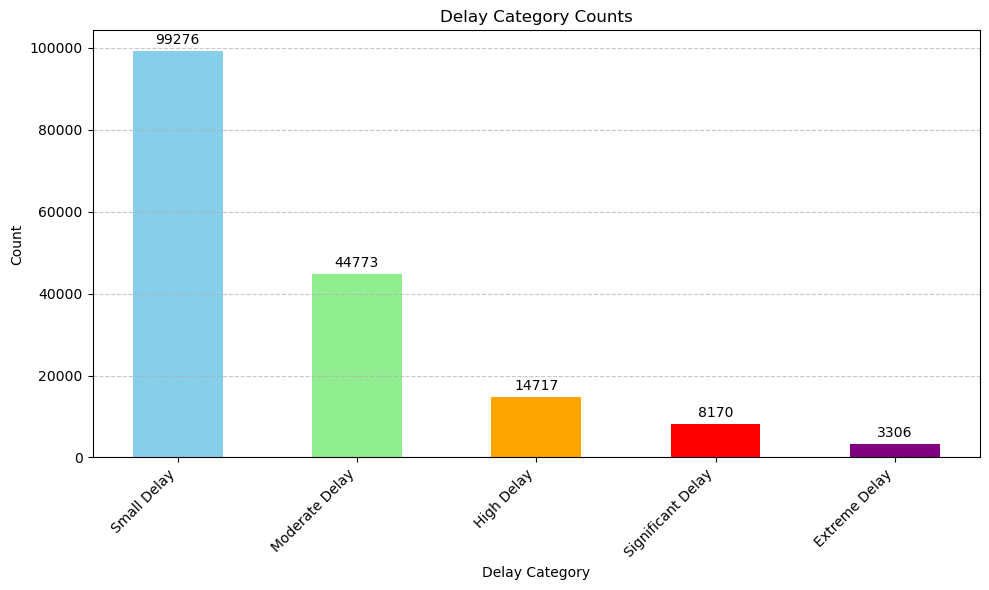

In [21]:
#Plotting the various delay category counts
delay_counts = data['delay_category'].value_counts().sort_index()

labels = ['Small Delay', 'Moderate Delay','High Delay', 'Significant Delay', 'Extreme Delay']
colors = ['skyblue', 'lightgreen', 'orange', 'red', 'purple']

x = delay_counts.index
width = 0.5

fig, ax = plt.subplots(figsize=(10, 6))

rects = ax.bar(x, delay_counts, width=width, color=colors)

ax.set_title('Delay Category Counts')
ax.set_xlabel('Delay Category')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for rect, label in zip(rects, delay_counts):
    height = rect.get_height()
    ax.annotate('{}'.format(label),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/delay_categories_counts.png') 
plt.show()

# Destination-related visualizations

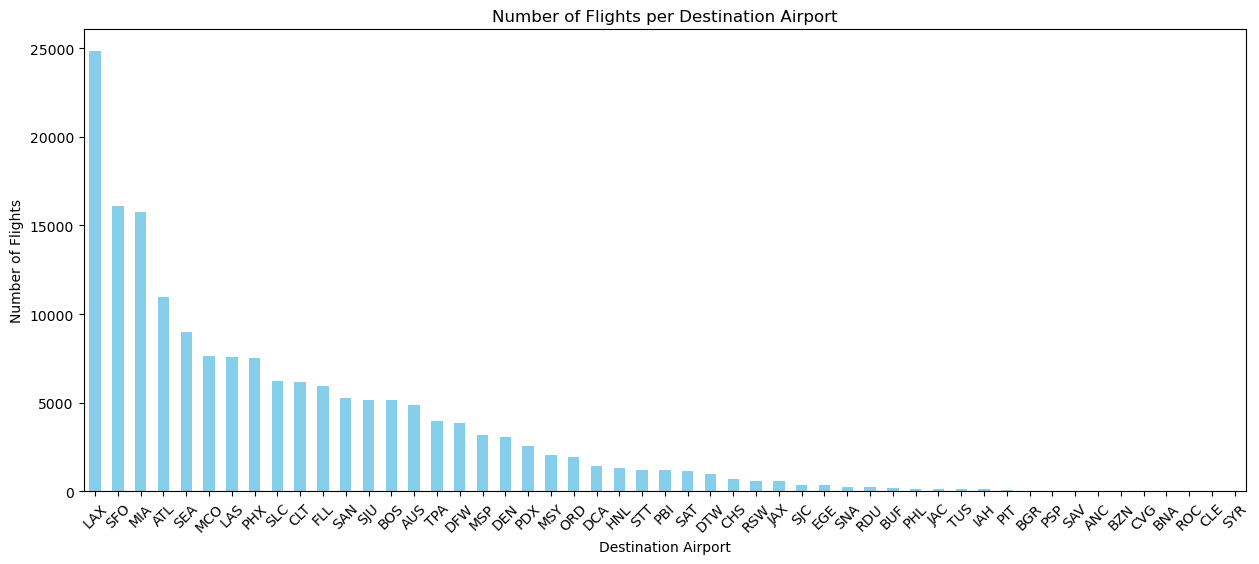

In [23]:
flight_counts = data['dest'].value_counts()

plt.figure(figsize=(15, 6))
flight_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Flights per Destination Airport')
plt.xlabel('Destination Airport')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/flight_per_destination.png') 
plt.show()

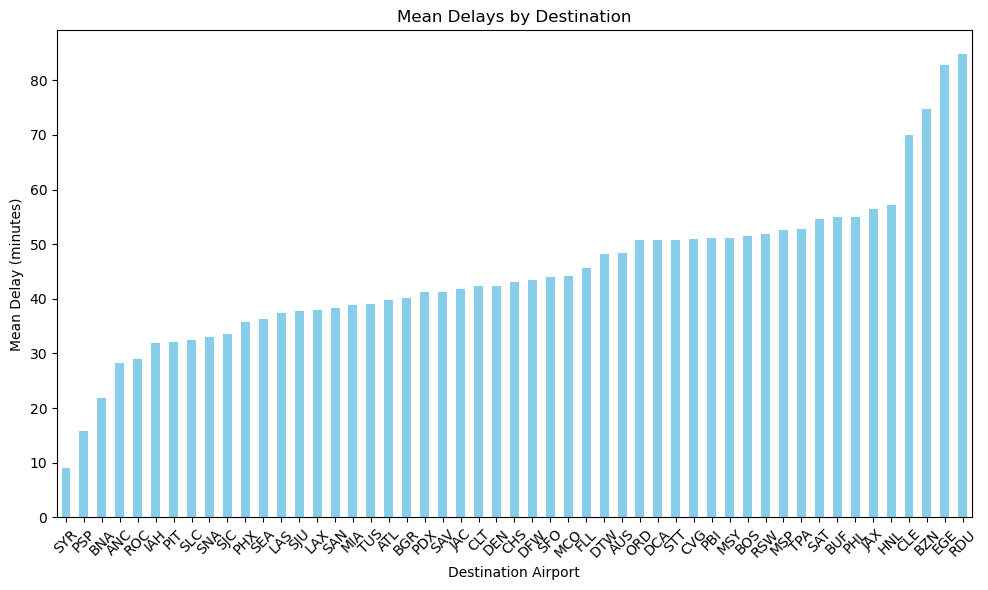

In [24]:
plt.figure(figsize=(10, 6))
dest_delay_stats['mean'].sort_values().plot(kind='bar', color='skyblue')
plt.title('Mean Delays by Destination')
plt.xlabel('Destination Airport')
plt.ylabel('Mean Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/mean_delays_by_destination.png') 
plt.show()

**From the above plots, we can see that the highest number of flights scheduled are for the LAX airport but the airport with the highest mean delays are for RDU - Raleigh Durham, North Carolina**

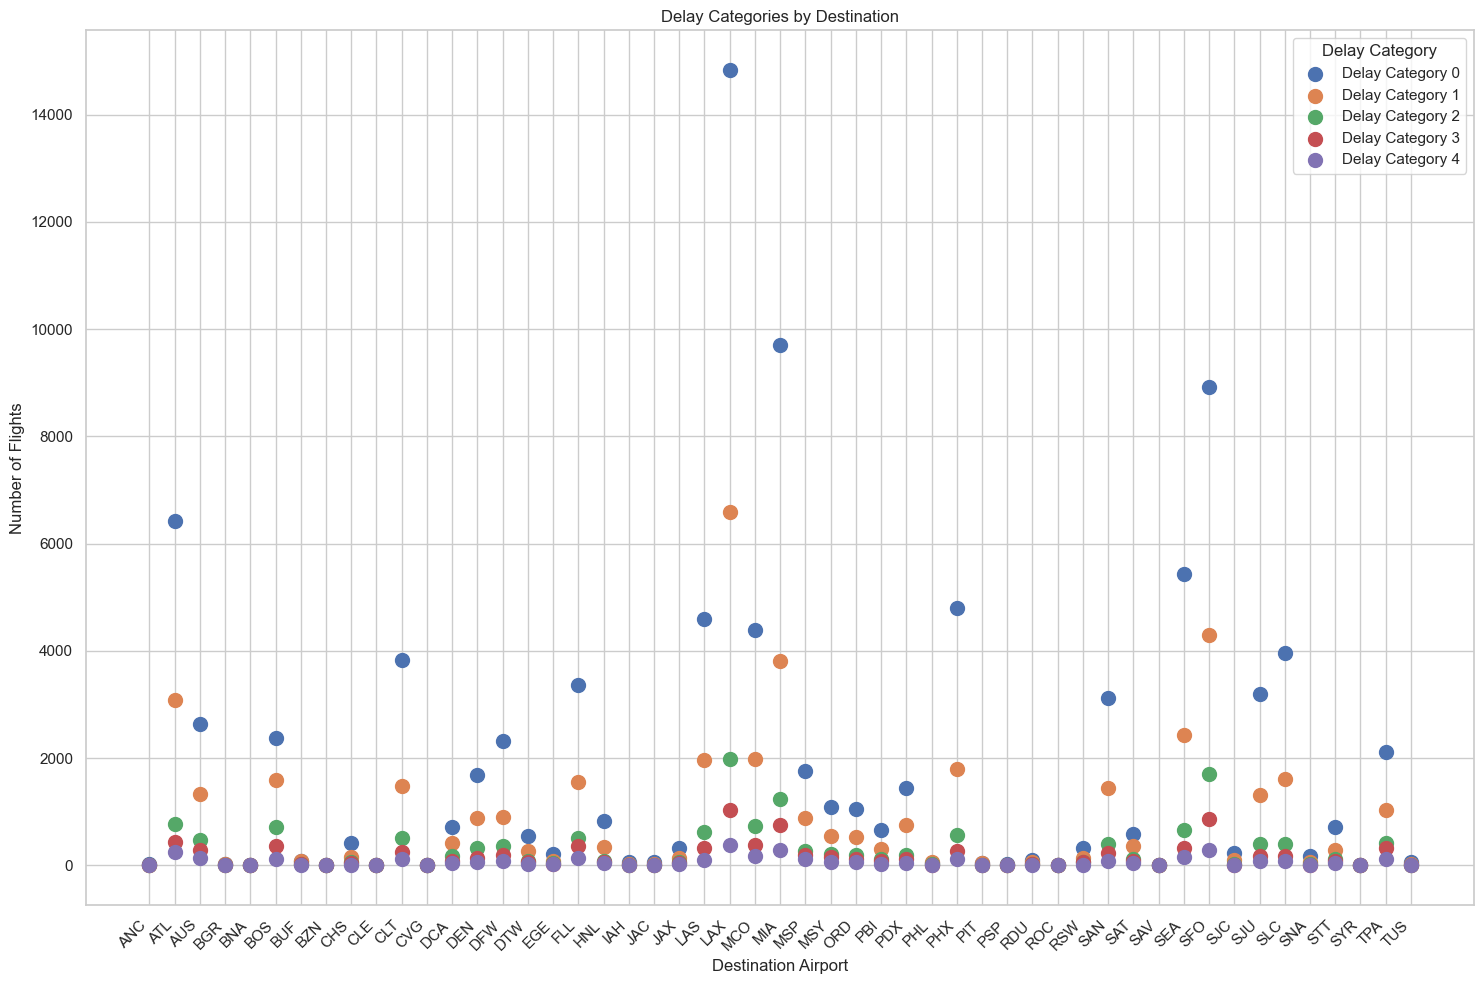

In [68]:
delay_counts = data.groupby(['dest', 'delay_category']).size().unstack(fill_value=0)
delay_counts = delay_counts.reset_index()

labels = delay_counts['dest']
categories = delay_counts.columns[1:]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(15, 10))

for i, category in enumerate(categories):
    ax.scatter(x, delay_counts[category], label=f'Delay Category {category}', s=100) 

ax.set_title('Delay Categories by Destination')
ax.set_xlabel('Destination Airport')
ax.set_ylabel('Number of Flights')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend(title='Delay Category')

fig.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/delay_categories_by_destination_scatter.png') 
plt.show()

**From the above plot, we see that delay categories 2 and 3, a delay of 60 to 120 minutes are pretty common and occur even at airports having less than 5000 incoming flights. Notably, Extreme delay categories of more than 240 minutes seem to occur at every destination airport and therefore this research is important to help tackle this issue**

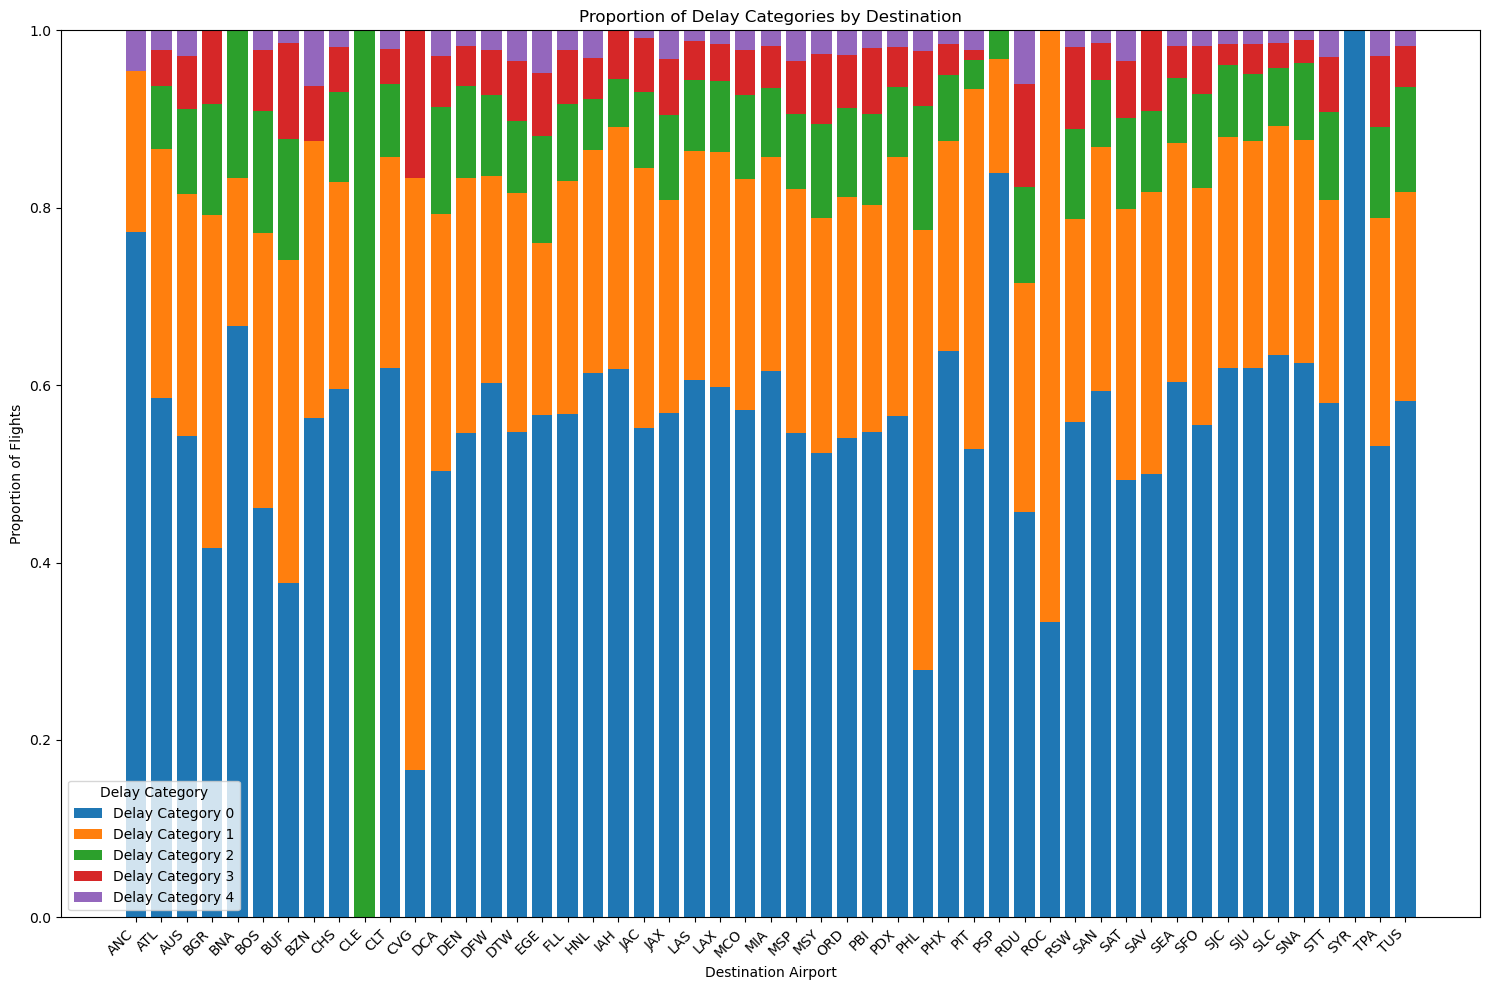

In [29]:
delay_counts = data.groupby(['dest', 'delay_category']).size().unstack(fill_value=0)

# Calculating the proportion of each delay category per destination
delay_proportions = delay_counts.div(delay_counts.sum(axis=1), axis=0)

delay_proportions = delay_proportions.reset_index()

labels = delay_proportions['dest']
categories = delay_proportions.columns[1:]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(15, 10))

bottom = np.zeros(len(labels))

for category in categories:
    ax.bar(x, delay_proportions[category], label=f'Delay Category {category}', bottom=bottom)
    bottom += delay_proportions[category]

ax.set_title('Proportion of Delay Categories by Destination')
ax.set_xlabel('Destination Airport')
ax.set_ylabel('Proportion of Flights')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend(title='Delay Category')

fig.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/proportion_delay_categories_by_destination.png') 
plt.show()

# Time-related visualizations

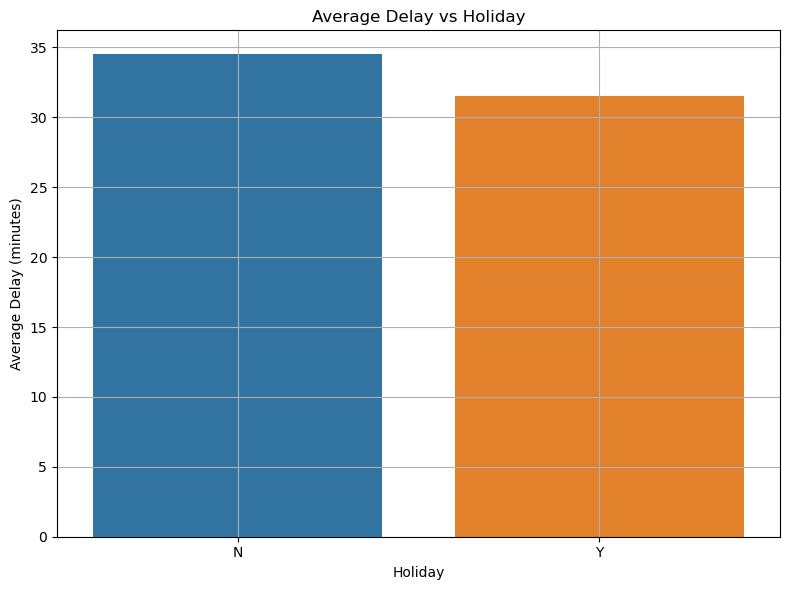

In [30]:
avg_delay_by_holiday = data.groupby('is_holiday')['dep_delay'].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_delay_by_holiday.index, y=avg_delay_by_holiday.values)

plt.title('Average Delay vs Holiday')
plt.xlabel('Holiday')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/delay vs holiday.png') 
plt.show()

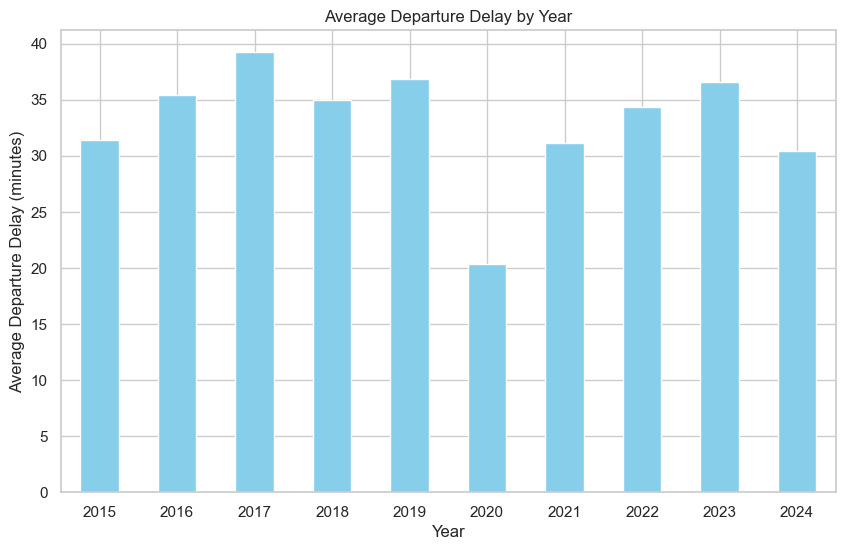

In [69]:
#Highest True Departure delays have been in 2017 and lowest was still in 2020
data['flight_date'] = pd.to_datetime(data['flight_date'])
data['year'] = data['flight_date'].dt.year

delay_by_year = data.groupby('year')['dep_delay'].mean()

plt.figure(figsize=(10, 6))
delay_by_year.plot(kind='bar', color='skyblue')
plt.title('Average Departure Delay by Year')
plt.xlabel('Year')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=0)
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_by_year.png') 
plt.show()

**From the above plots, average delay was highest in 2017 and lowest in 2020; this can be attributed to the COVID-19 pandemic causing a halt in air travel**

**Also there was a world-wide surge in travel that took place in 2022 termed as Revenge travel which could also be an underlying reason contributing to delays**

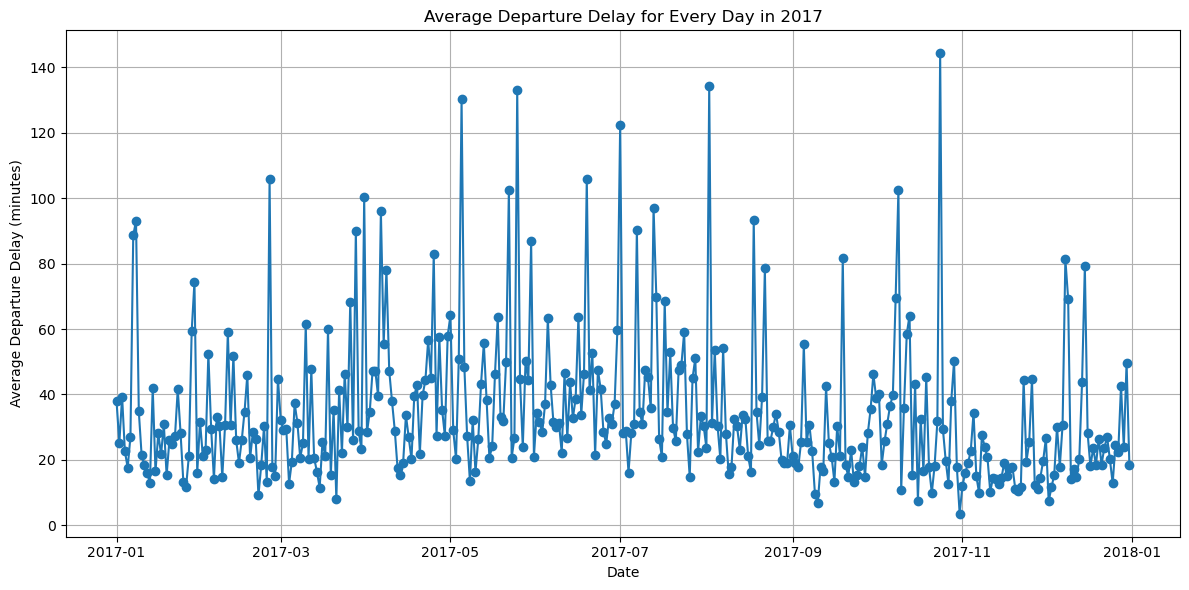

In [32]:
#Drilling down to see any trends in the year 2017 as it has the highest average delays
df_2017 = data[data['flight_date'].dt.year == 2017]

avg_delay_by_day = df_2017.groupby(df_2017['flight_date'].dt.date)['dep_delay'].mean()
plt.figure(figsize=(12, 6))
avg_delay_by_day.plot(marker='o', linestyle='-')

plt.title('Average Departure Delay for Every Day in 2017')
plt.xlabel('Date')
plt.ylabel('Average Departure Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_everyday_2017.png') 
plt.show()

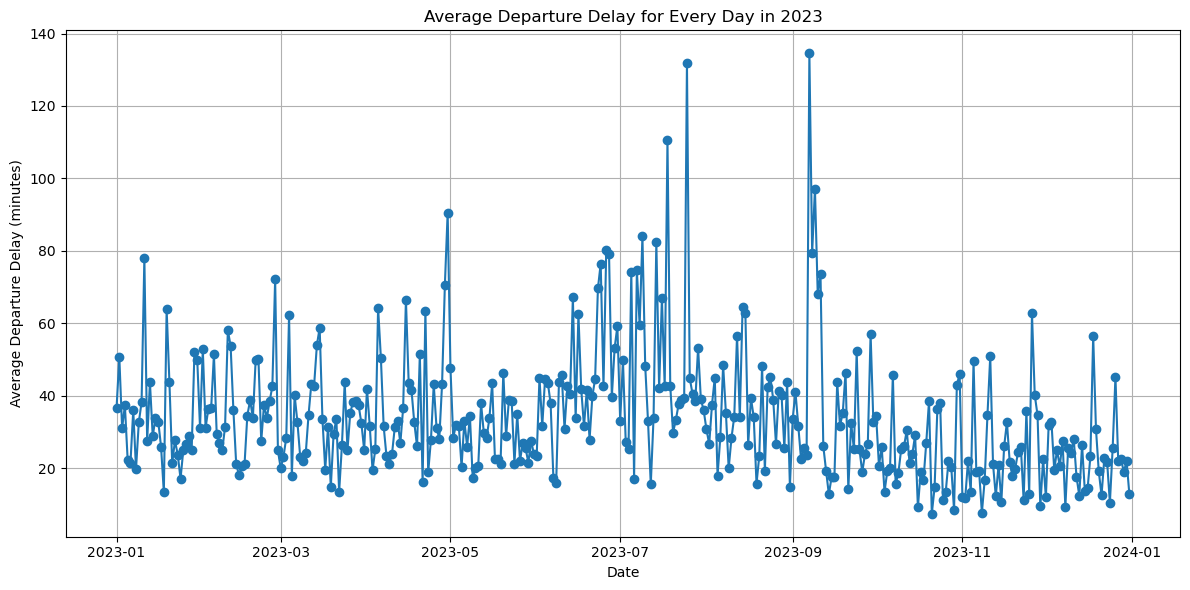

In [33]:
#We see a consistent cycle throughout the year so we tried plotting the same graoh for other years to see the difference
#comparing with 2023 as it has the 2nd highest average delays
df_2023 = data[data['flight_date'].dt.year == 2023]

avg_delay_by_day = df_2023.groupby(df_2023['flight_date'].dt.date)['dep_delay'].mean()
plt.figure(figsize=(12, 6))
avg_delay_by_day.plot(marker='o', linestyle='-')

plt.title('Average Departure Delay for Every Day in 2023')
plt.xlabel('Date')
plt.ylabel('Average Departure Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_everyday_2023.png') 
plt.show()

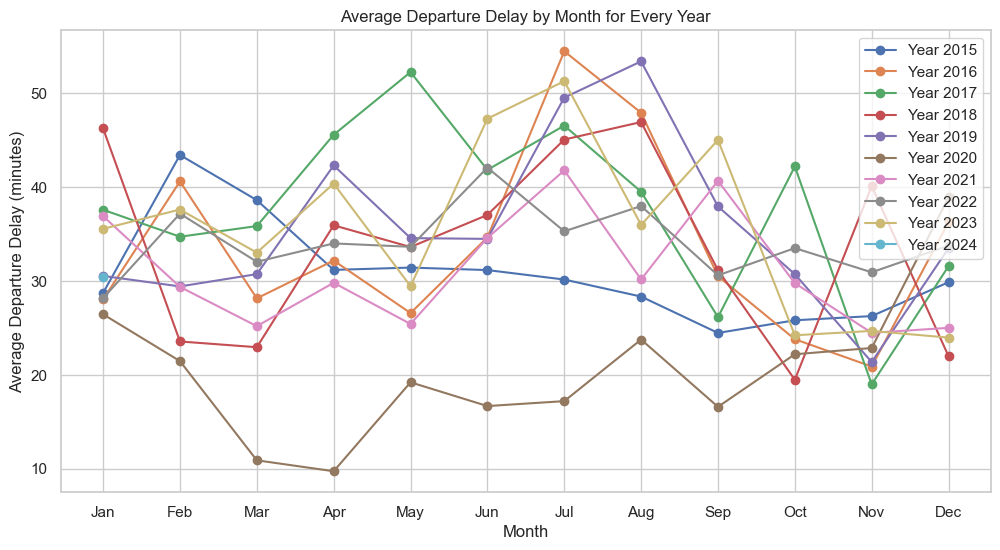

In [70]:
data['year'] = data['flight_date'].dt.year

delay_by_month = data.groupby(['year', 'month'])['dep_delay'].mean()

fig, ax = plt.subplots(figsize=(12, 6))

for year in data['year'].unique():
    yearly_data = delay_by_month[year]
    ax.plot(yearly_data.index, yearly_data.values, marker='o', label=f'Year {year}')

ax.set_title('Average Departure Delay by Month for Every Year')
ax.set_xlabel('Month')
ax.set_ylabel('Average Departure Delay (minutes)')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper right')
plt.grid(True)
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_by_month_per_year.png') 
plt.show()

**From the above plot, we can see that overall the highest delays occur in the months of June, July, August, which is the summer season**

**It can also be noticed that the highest delays in the whole timeline happened in the month of July 2016 and August 2019. The year 2019 was still undergoing flight restrictions due to the COVID-19 pandemic and high delays in August could be a resulting effet of that**

**To confirm this, I will plot another visual displaying Mean Departure Delays By Season**

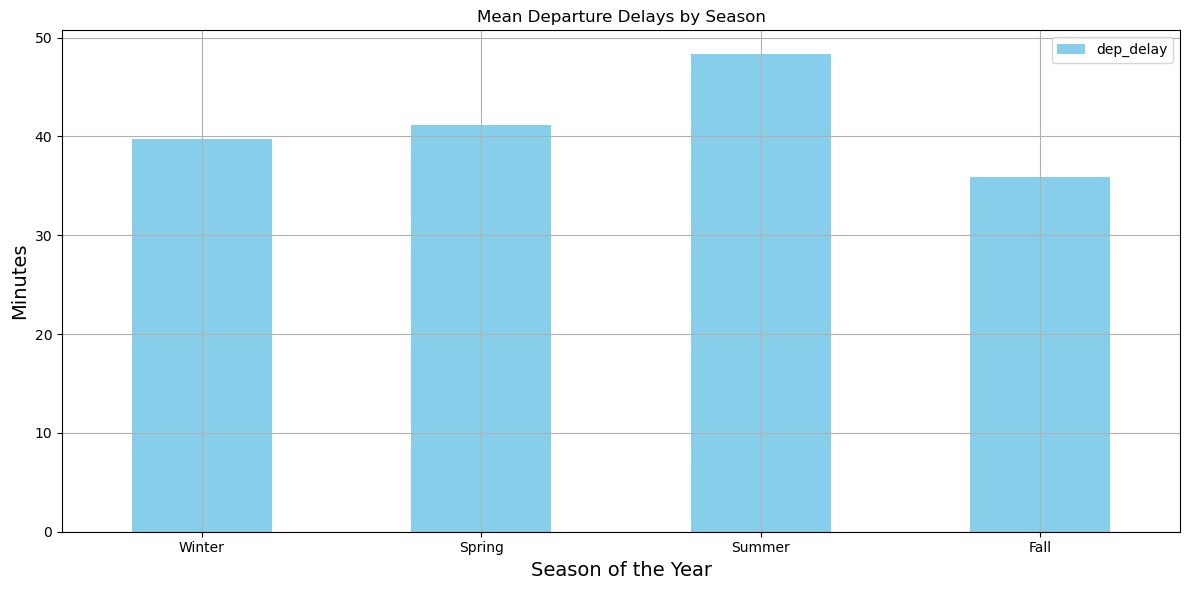

In [35]:
data_filtered = data[data['dep_delay'] > 0]

fig, ax = plt.subplots(figsize=(12, 6))

# Mean Departure Delay
data_filtered.groupby('season')['dep_delay'].mean().plot.bar(color='skyblue', ax=ax)
ax.set_title('Mean Departure Delays by Season')
ax.set_ylabel('Minutes', fontsize=14)
ax.set_xlabel('Season of the Year', fontsize=14)
ax.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'], rotation=0)
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_by_season.png') 
plt.show()

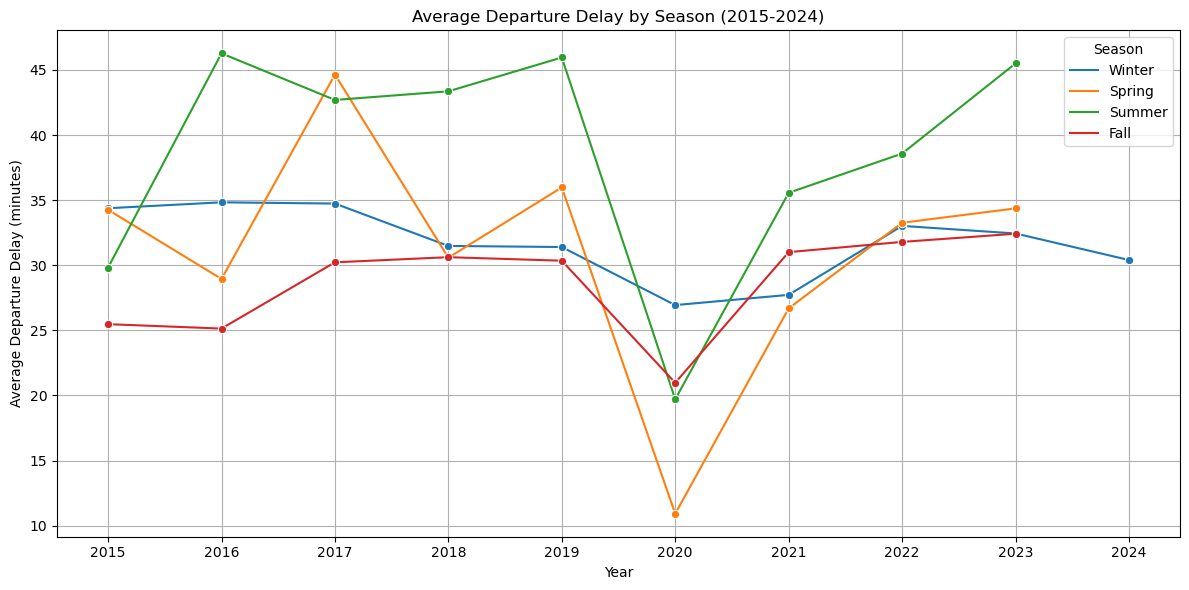

In [36]:
#Drilling down to delay every season every year
avg_delay_by_season = data.groupby(['year', 'season'])['dep_delay'].mean().reset_index()

season_mapping = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_delay_by_season, x='year', y='dep_delay', hue='season', marker='o')

handles, labels = plt.gca().get_legend_handles_labels()
labels = [season_mapping[int(label)] for label in labels]
plt.legend(handles=handles, labels=labels, title='Season')

plt.title('Average Departure Delay by Season (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Average Departure Delay (minutes)')
plt.grid(True)
plt.xticks(range(2015, 2025))
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_by_season_per_year.png') 
plt.show()

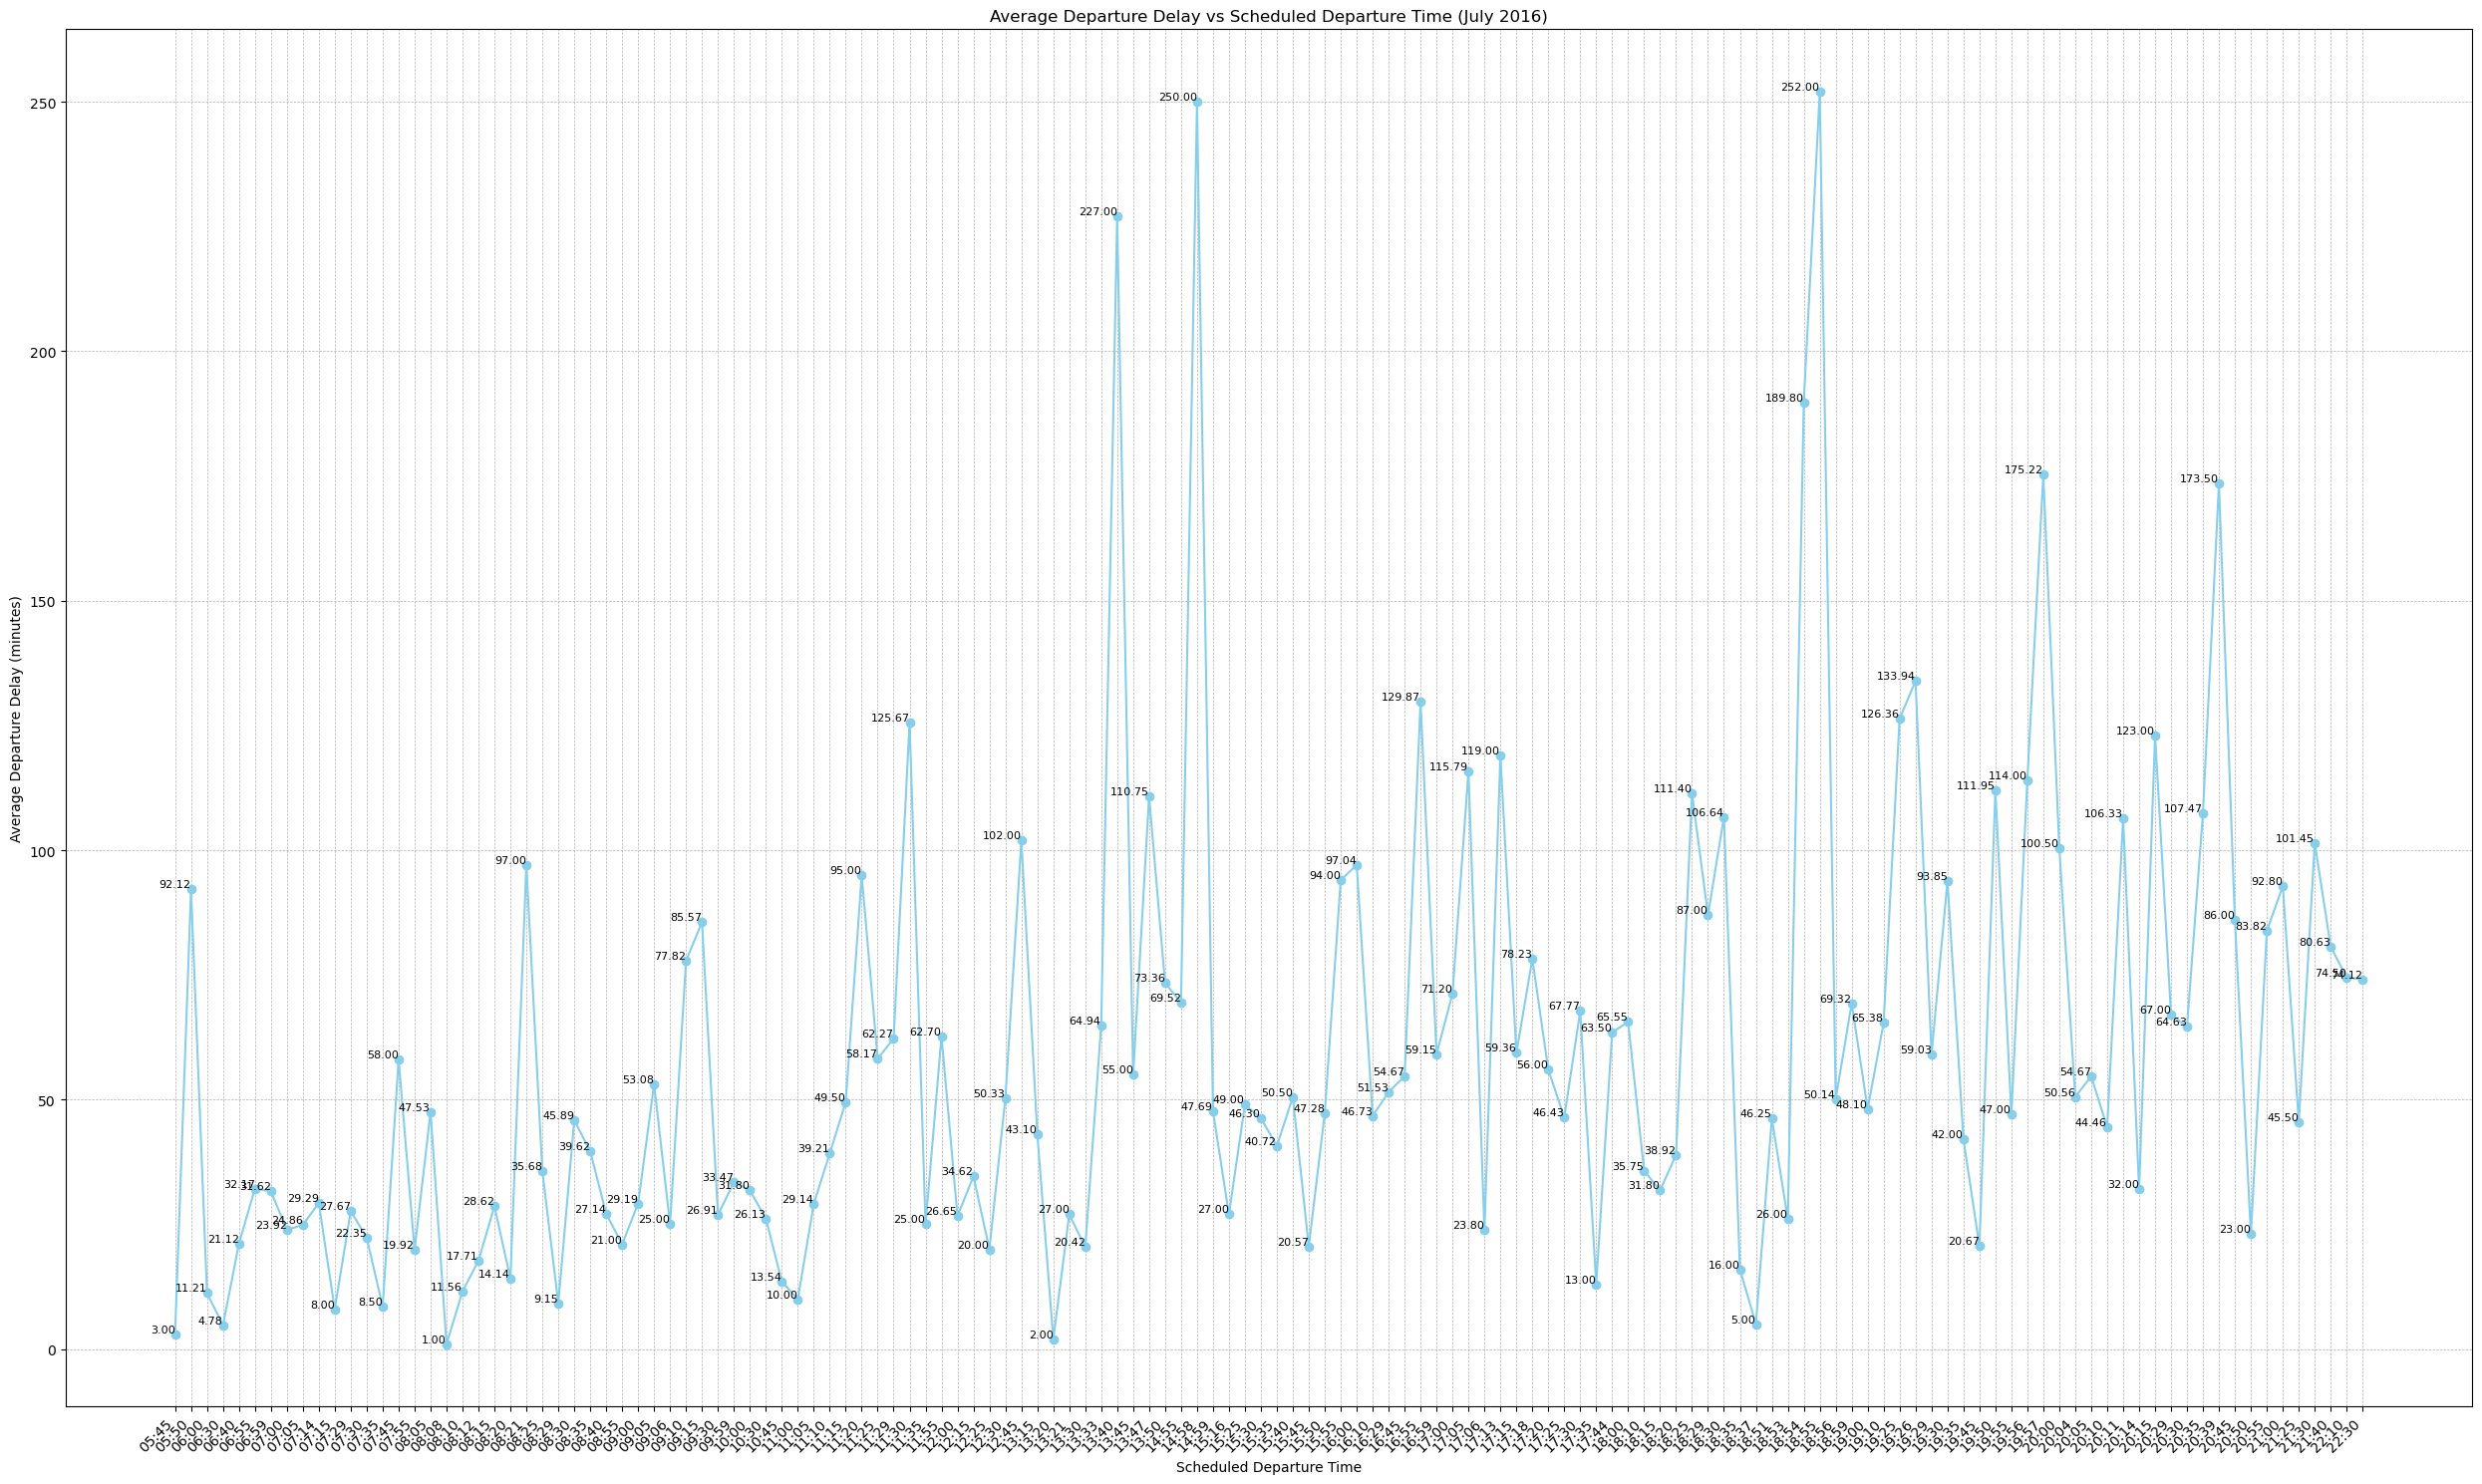

In [37]:
#Plotting data for July 2016 as delay was highest for this month from one of the previous plots - need to fix x axis
data_filtered = data[(data['year'] == 2016) & (data['month'] == 7) & (data['dep_delay'] > 0)]

data_aggregated = data_filtered.groupby('scheduled_dep')['dep_delay'].mean().reset_index()

plt.figure(figsize=(25, 15))
plt.plot(data_aggregated['scheduled_dep'], data_aggregated['dep_delay'], marker='o', linestyle='-', color='skyblue')
plt.title('Average Departure Delay vs Scheduled Departure Time (July 2016)')
plt.xlabel('Scheduled Departure Time')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45, ha='right') 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

for x, y in zip(data_aggregated['scheduled_dep'], data_aggregated['dep_delay']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=8)
    
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_vs_scheduled_dep.png') 
plt.show()

**Initially plotted delays vs Scheduled departure but since the graph was too cluttered I took an average. Grouped by Scheduled departure time, I have taken the mean Departure delay across the month of July for the year 2016 as it showed the highest delays in the previous plots. We can observe a lot of fluctuations throughout the day over the whole period. Highest delays were seen between 2.55 to 3.15 in the afternoon but since there is a general variation and not a gradual pattern, I don't think time of day can alone be considered as an impacting factor for this time period. To confirm this, I tried and tested by plotting serveral different months across the years, below plot is the plot for March 2023** 

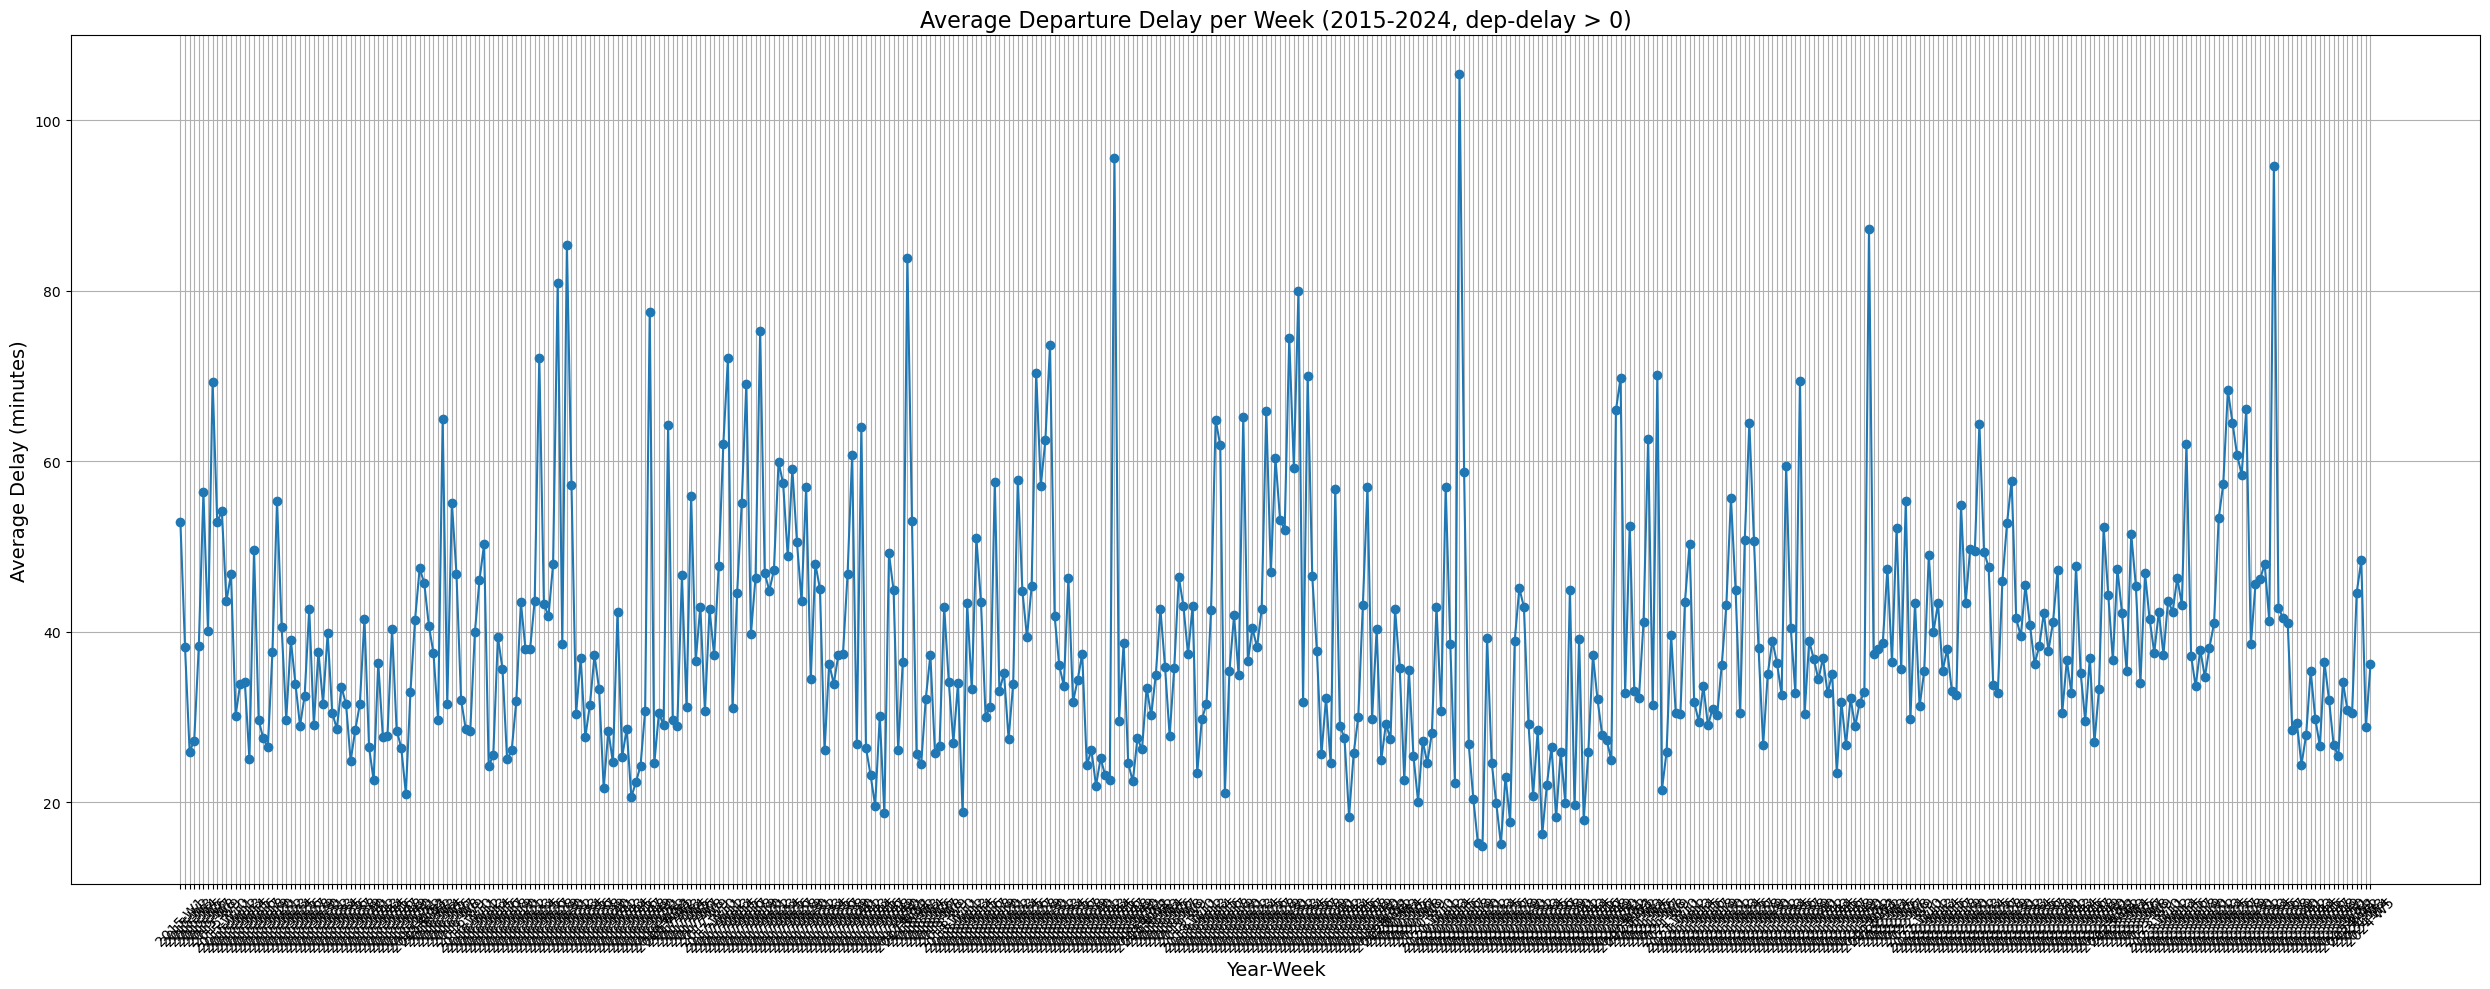

In [38]:
#Plotted average delay per week but plot is not very readable
data['week'] = data['flight_date'].dt.isocalendar().week

data_filtered = data[data['dep_delay'] > 0]
data_filtered = data_filtered[(data_filtered['year'] >= 2015) & (data_filtered['year'] <= 2024)]
average_delay_per_week = data_filtered.groupby(['year', 'week'])['dep_delay'].mean().reset_index()

plt.figure(figsize=(25, 10))
plt.plot(average_delay_per_week['year'].astype(str) + '-W' + average_delay_per_week['week'].astype(str),
         average_delay_per_week['dep_delay'], marker='o', linestyle='-')
plt.title('Average Departure Delay per Week (2015-2024, dep-delay > 0)', fontsize=16)
plt.xlabel('Year-Week', fontsize=14)
plt.ylabel('Average Delay (minutes)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_per_week.png') 
plt.show()

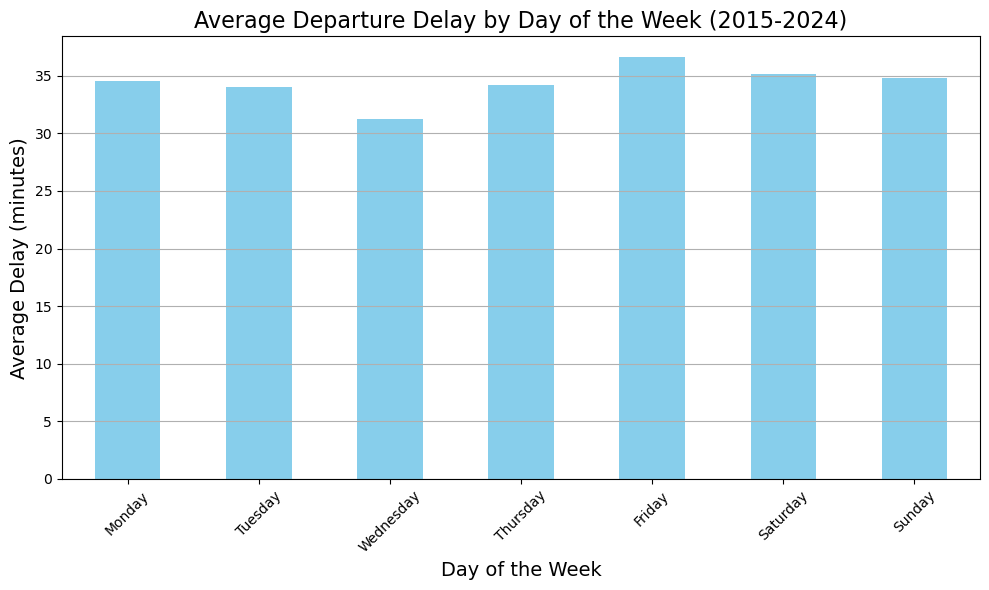

In [39]:
#Plotted average departure for day of the week, plot is not useful #also takes on time and early flights, replot
data_filtered = data[(data['flight_date'].dt.year >= 2015) & (data['flight_date'].dt.year <= 2024)]
average_delay_per_day = data_filtered.groupby('day_of_week')['dep_delay'].mean().reset_index()

plt.figure(figsize=(10, 6))
average_delay_per_day.set_index('day_of_week')['dep_delay'].loc[
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
].plot(kind='bar', color='skyblue')
plt.title('Average Departure Delay by Day of the Week (2015-2024)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Average Delay (minutes)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_by_day.png') 
plt.show()

**Higher delays seen in the second half of the week**

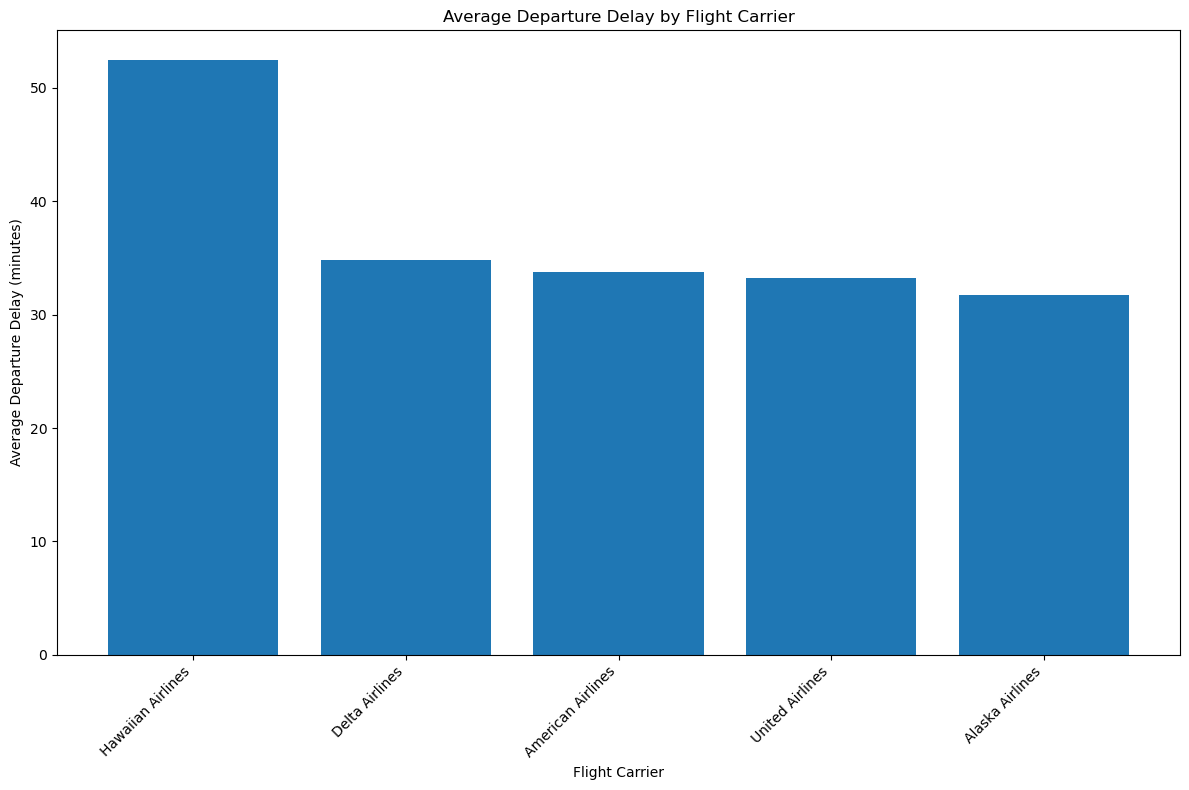

In [40]:
#To verify the SelectKBest, I plotted Flight Departure Delays by carrier which was not done before as part of EDA to see 
#if there is a vast difference in delays among flight carriers
carrier_avg_delay = data.groupby('carrier')['dep_delay'].mean()

carrier_avg_delay = carrier_avg_delay.sort_values(ascending=False)

carrier_full_names = {
    'DL': 'Delta Airlines',
    'AA': 'American Airlines',
    'AS': 'Alaska Airlines',
    'UA': 'United Airlines',
    'HA': 'Hawaiian Airlines'
}

plt.figure(figsize=(12, 8))
plt.bar(range(len(carrier_avg_delay)), carrier_avg_delay.values, tick_label=[carrier_full_names[carrier] for carrier in carrier_avg_delay.index])
plt.title('Average Departure Delay by Flight Carrier')
plt.xlabel('Flight Carrier')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_carrier.png')
plt.show()

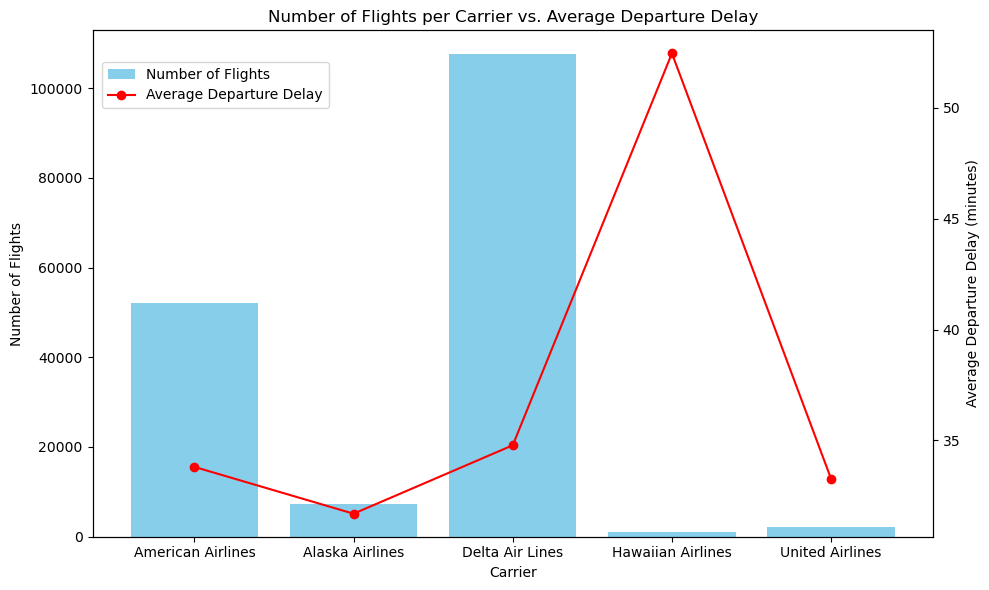

In [48]:
#Plotting Number of Flights vs Delays for each carrier
carrier_stats = data.groupby('carrier').agg({'carrier': 'count', 'dep_delay': 'mean'})
carrier_stats.columns = ['num_flights', 'avg_departure_delay']

# Resetting the index to make 'carrier' a column instead of index
carrier_stats.reset_index(inplace=True)

# Dictionary mapping carrier codes to airline names
carrier_names = {
    'AA': 'American Airlines',
    'DL': 'Delta Air Lines',
    'UA': 'United Airlines',
    'AS': 'Alaska Airlines',
    'HA': 'Hawaiian Airlines'
}

# Replacing carrier codes with full airline names
carrier_stats['carrier'] = carrier_stats['carrier'].map(carrier_names)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting number of flights on the primary y-axis
ax1.bar(carrier_stats['carrier'], carrier_stats['num_flights'], color='skyblue', label='Number of Flights')
ax1.set_xlabel('Carrier')
ax1.set_ylabel('Number of Flights', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Creating a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(carrier_stats['carrier'], carrier_stats['avg_departure_delay'], marker='o', color='red', label='Average Departure Delay')
ax2.set_ylabel('Average Departure Delay (minutes)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and legends
plt.title('Number of Flights per Carrier vs. Average Departure Delay')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Saving the plot
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/flights_per_carrier_vs_delay_axis.png')
plt.show()

# Visualizations with weather

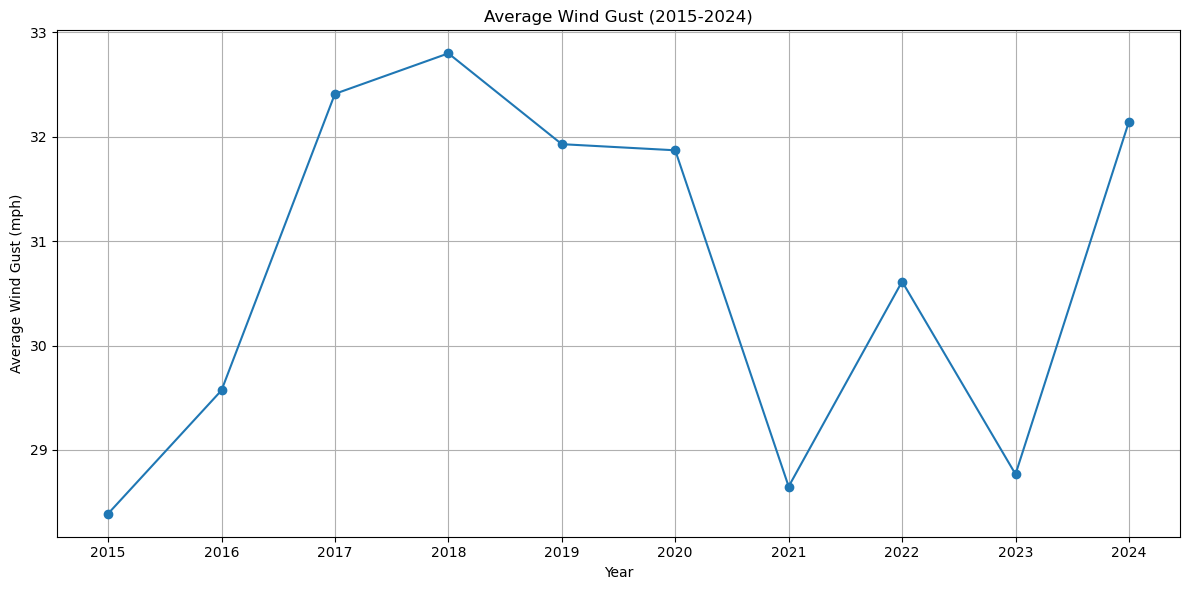

In [49]:
avg_wind_gust_by_year = data.groupby('year')['wind_gusts_10m'].mean()

plt.figure(figsize=(12, 6))
plt.plot(avg_wind_gust_by_year.index, avg_wind_gust_by_year.values, marker='o', linestyle='-')

plt.title('Average Wind Gust (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Average Wind Gust (mph)')
plt.grid(True)
plt.xticks(range(2015, 2025))
plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_wind_gust_by_year.png') 
plt.show()

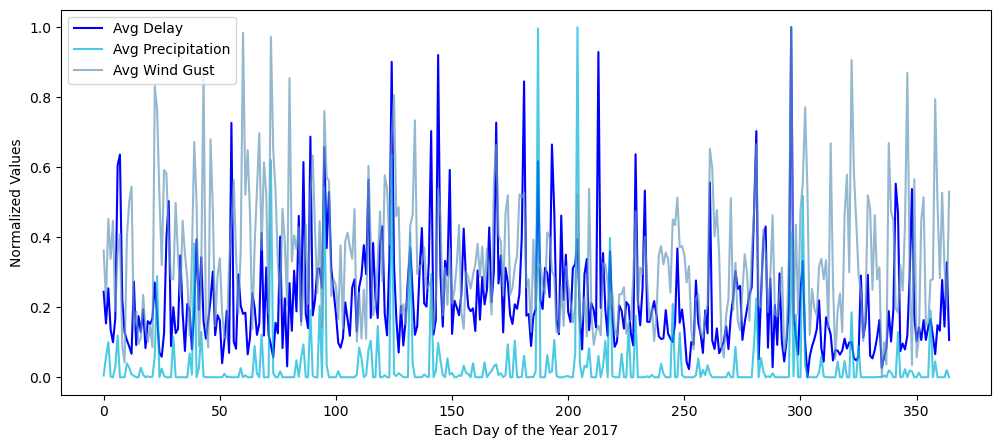

In [50]:
#Looking at Delays and major weather factors like Wind gust and precipitation for the year 2017 as it has the highest average delays
temp_df = data[data['year'] == 2017]

daily_data = temp_df.groupby('flight_date').agg(
    {'dep_delay': 'mean',
     'temperature': 'mean',
     'precipitation': 'mean',
     'wind_speed_100m': 'mean',
     'wind_gusts_10m': 'mean',
     'cloud_cover': 'mean',
     'wind_direction_100m': 'mean'}).reset_index()

scaler = MinMaxScaler()
delay_data_normalized = scaler.fit_transform(pd.DataFrame(daily_data['dep_delay']))
precipitation_data_normalized = scaler.fit_transform(pd.DataFrame(daily_data['precipitation']))
wind_gust_data_normalized = scaler.fit_transform(pd.DataFrame(daily_data['wind_gusts_10m']))

x_axis = list(range(len(daily_data)))

plt.figure(figsize=(12, 5))

plt.plot(x_axis, delay_data_normalized, label='Avg Delay', color='blue')
plt.plot(x_axis, precipitation_data_normalized, label='Avg Precipitation', color='#00b4d8', alpha=0.7)
plt.plot(x_axis, wind_gust_data_normalized, label='Avg Wind Gust', color='#669bbc', alpha=0.7)
plt.xlabel('Each Day of the Year 2017')
plt.ylabel('Normalized Values')

plt.legend()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_vs_wind_precipitation.png') 
plt.show()

**Both Wind gust and precipitation move in a close range to Delays throughout the year and these factors could be correlated**

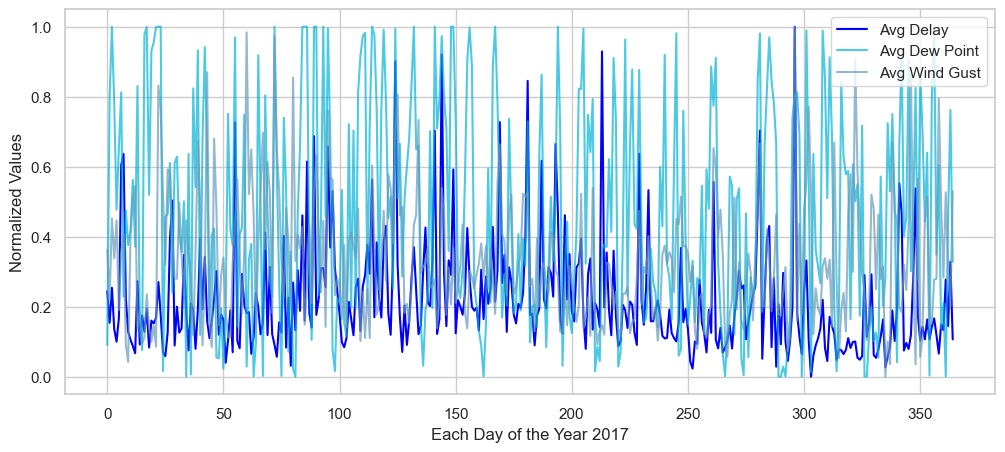

In [73]:
#Looking at Delays and major weather factors like Wind gust and precipitation for the year 2017 as it has the highest average delays
temp_df = data[data['year'] == 2017]

daily_data = temp_df.groupby('flight_date').agg(
    {'dep_delay': 'mean',
     'temperature': 'mean',
     'precipitation': 'mean',
     'wind_speed_100m': 'mean',
     'wind_gusts_10m': 'mean',
     'cloud_cover': 'mean',
     'dew_point':'mean',
     'wind_direction_100m': 'mean'}).reset_index()

scaler = MinMaxScaler()
delay_data_normalized = scaler.fit_transform(pd.DataFrame(daily_data['dep_delay']))
cloud_data_normalized = scaler.fit_transform(pd.DataFrame(daily_data['cloud_cover']))
wind_gust_data_normalized = scaler.fit_transform(pd.DataFrame(daily_data['wind_gusts_10m']))

x_axis = list(range(len(daily_data)))

plt.figure(figsize=(12, 5))

plt.plot(x_axis, delay_data_normalized, label='Avg Delay', color='blue')
plt.plot(x_axis, cloud_data_normalized, label='Avg Dew Point', color='#00b4d8', alpha=0.7)
plt.plot(x_axis, wind_gust_data_normalized, label='Avg Wind Gust', color='#669bbc', alpha=0.7)
plt.xlabel('Each Day of the Year 2017')
plt.ylabel('Normalized Values')

plt.legend()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_vs_wind_cloud.png') 
plt.show()

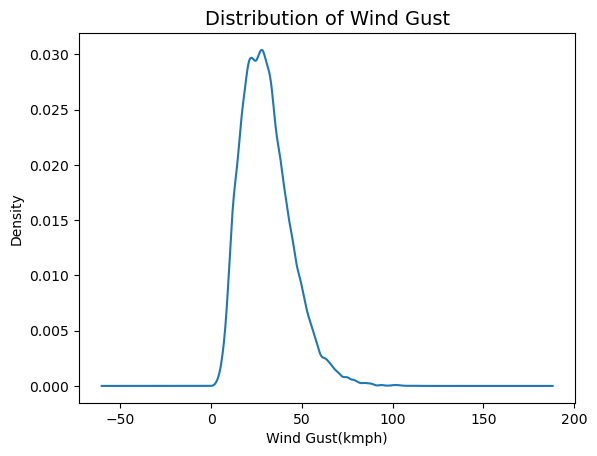

In [51]:
data['wind_gusts_10m'].plot(kind='kde')
plt.title("Distribution of Wind Gust", fontsize=14)
plt.xlabel("Wind Gust(kmph)")
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/wind_gust_dist.png') 
#As per articles,wind gust of 60 kmph and above is risky as it makes walking difficult and worsens as the speed rises

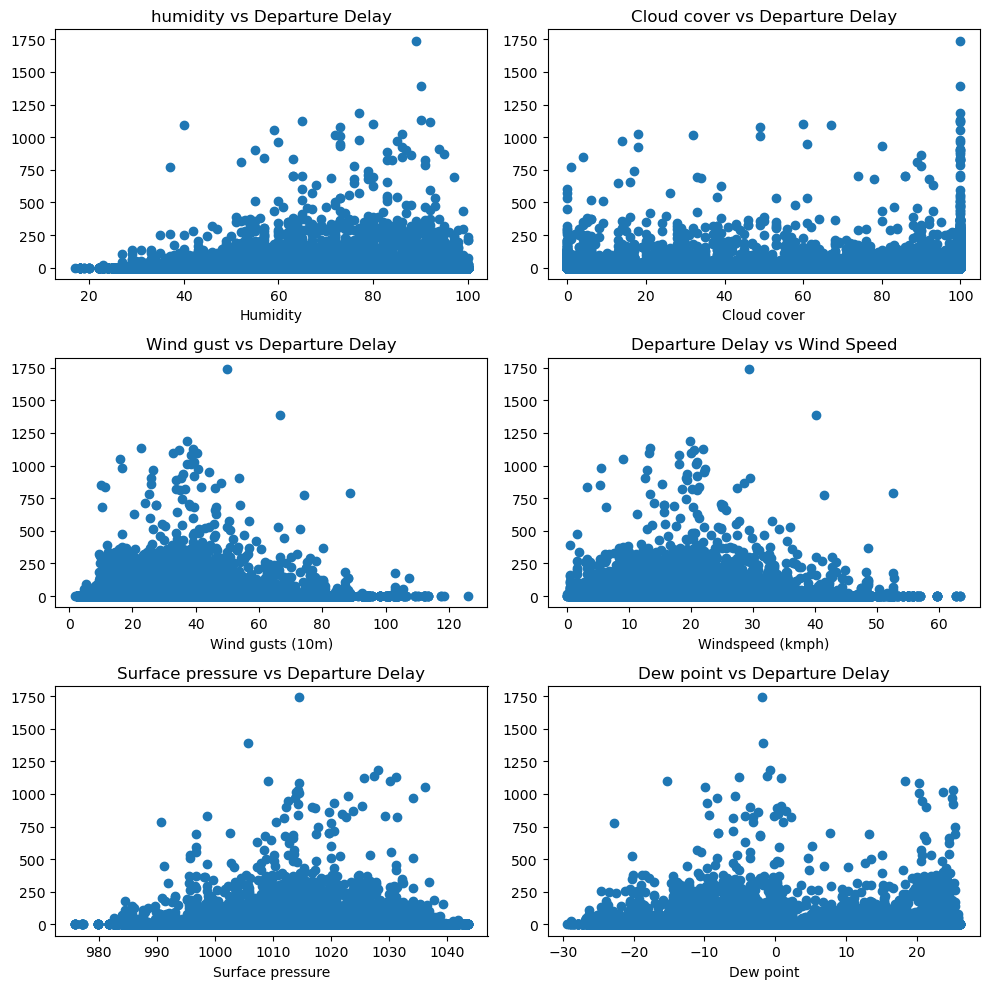

In [52]:
#Plotting the weather related parameters against Weather Related Delay minutes, i chose this after plotting everything
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs[0, 0].scatter(data['humidity'], data['delay_weather'])
axs[0, 0].set_xlabel('Humidity')
axs[0, 0].set_title('humidity vs Departure Delay')

axs[1, 0].scatter(data['wind_gusts_10m'], data['delay_weather'])
axs[1, 0].set_xlabel('Wind gusts (10m)')
axs[1, 0].set_title('Wind gust vs Departure Delay')

axs[0, 1].scatter(data['cloud_cover'], data['delay_weather'])
axs[0, 1].set_xlabel('Cloud cover')
axs[0, 1].set_title('Cloud cover vs Departure Delay')

axs[1, 1].scatter(data['wind_speed_10m'], data['delay_weather'])
axs[1, 1].set_xlabel('Windspeed (kmph)')
axs[1, 1].set_title('Departure Delay vs Wind Speed')

axs[2, 0].scatter(data['surface_pressure'], data['delay_weather'])
axs[2, 0].set_xlabel('Surface pressure')
axs[2, 0].set_title('Surface pressure vs Departure Delay')

axs[2, 1].scatter(data['dew_point'], data['delay_weather'])
axs[2, 1].set_xlabel('Dew point')
axs[2, 1].set_title('Dew point vs Departure Delay')

plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/weather_scatter_plot.png') 
plt.show()
#Add humidity, wind gust, cloud cover, wind speed, surface pressure, maybe dew point

**It is worth noticing from the above graph that Cloud cover and Humidity are directly proportional to Departure delays**

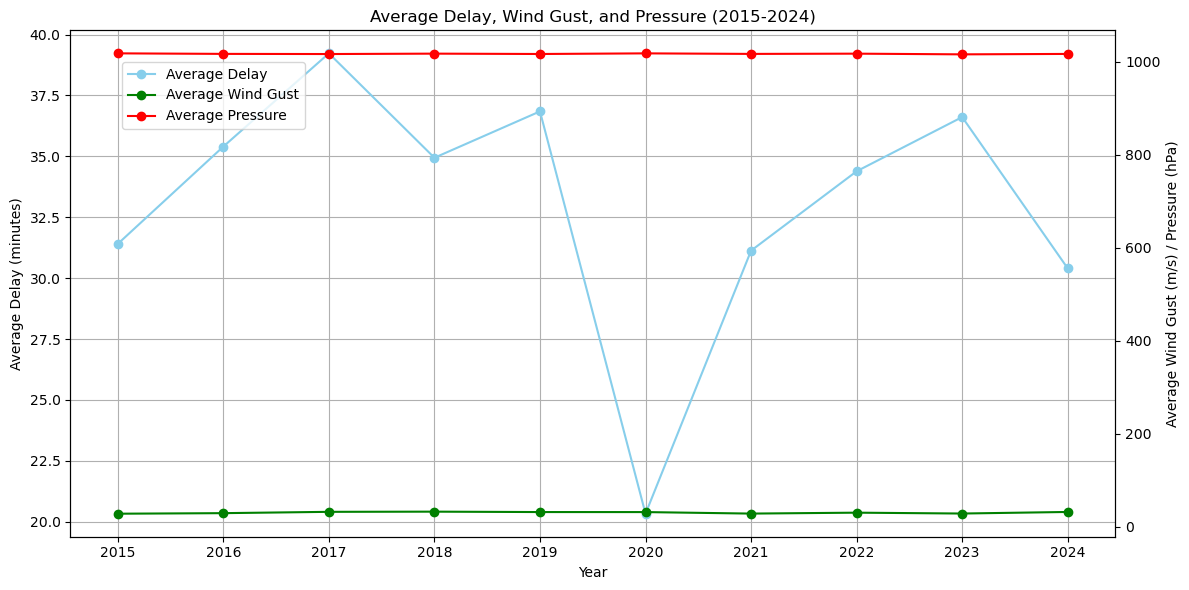

In [55]:
avg_delay_by_year = data.groupby('year')['dep_delay'].mean()
avg_wind_gust_by_year = data.groupby('year')['wind_gusts_10m'].mean()
avg_pressure_by_year = data.groupby('year')['pressure'].mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting average delay on the primary y-axis
ax1.plot(avg_delay_by_year.index, avg_delay_by_year.values, marker='o', linestyle='-', color='skyblue', label='Average Delay')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Delay (minutes)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Creating a secondary y-axis for wind gust and pressure
ax2 = ax1.twinx()
ax2.plot(avg_wind_gust_by_year.index, avg_wind_gust_by_year.values, marker='o', linestyle='-', color='green', label='Average Wind Gust')
ax2.plot(avg_pressure_by_year.index, avg_pressure_by_year.values, marker='o', linestyle='-', color='red', label='Average Pressure')
ax2.set_ylabel('Average Wind Gust (m/s) / Pressure (hPa)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and legends
plt.title('Average Delay, Wind Gust, and Pressure (2015-2024)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

# Setting x-axis ticks to show all years
plt.xticks(range(2015, 2025))

# Saving the plot
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/avg_delay_wind_pressure_by_year_axis.png')
plt.show()

# Correlation matrix

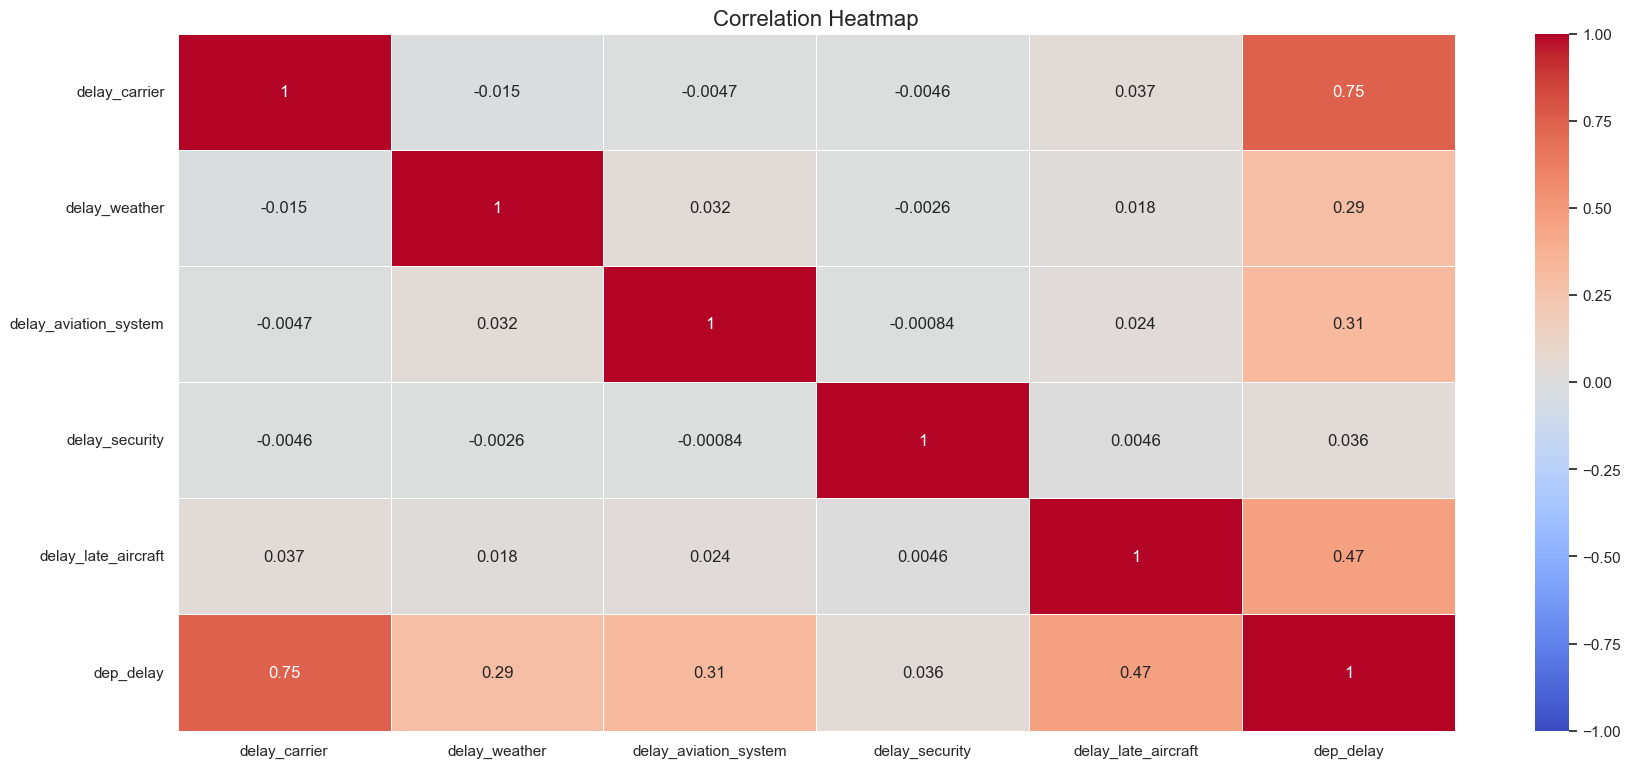

In [56]:
#Correlation heatmap of departure delay to type based delays
data_filtered = data[(data['flight_date'].dt.year >= 2015) & (data['flight_date'].dt.year <= 2024)]

sns.set(style="whitegrid")

plt.figure(figsize=(18, 15))
plt.subplot(2, 1, 2)
correlation_matrix = data_filtered[['delay_carrier', 'delay_weather', 'delay_aviation_system', 'delay_security', 'delay_late_aircraft', 'dep_delay']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)

plt.tight_layout()
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/correlation_with_delay.png') 
plt.show()

In [57]:
numerical_cols = ['dep_delay', 'scheduled_elapsed','temperature','dew_point','wind_speed_10m','delay_carrier','delay_weather',
                  'delay_aviation_system','delay_security','delay_late_aircraft','humidity','precipitation','rain','snowfall',
                  'cloud_cover','wind_direction_10m','wind_gusts_10m']
                  
categorical_cols = ['flight_num','dest','weekend','month','year','delay_category','season','wind_alert','is_holiday',
                    'weather_code','carrier','day_of_week']

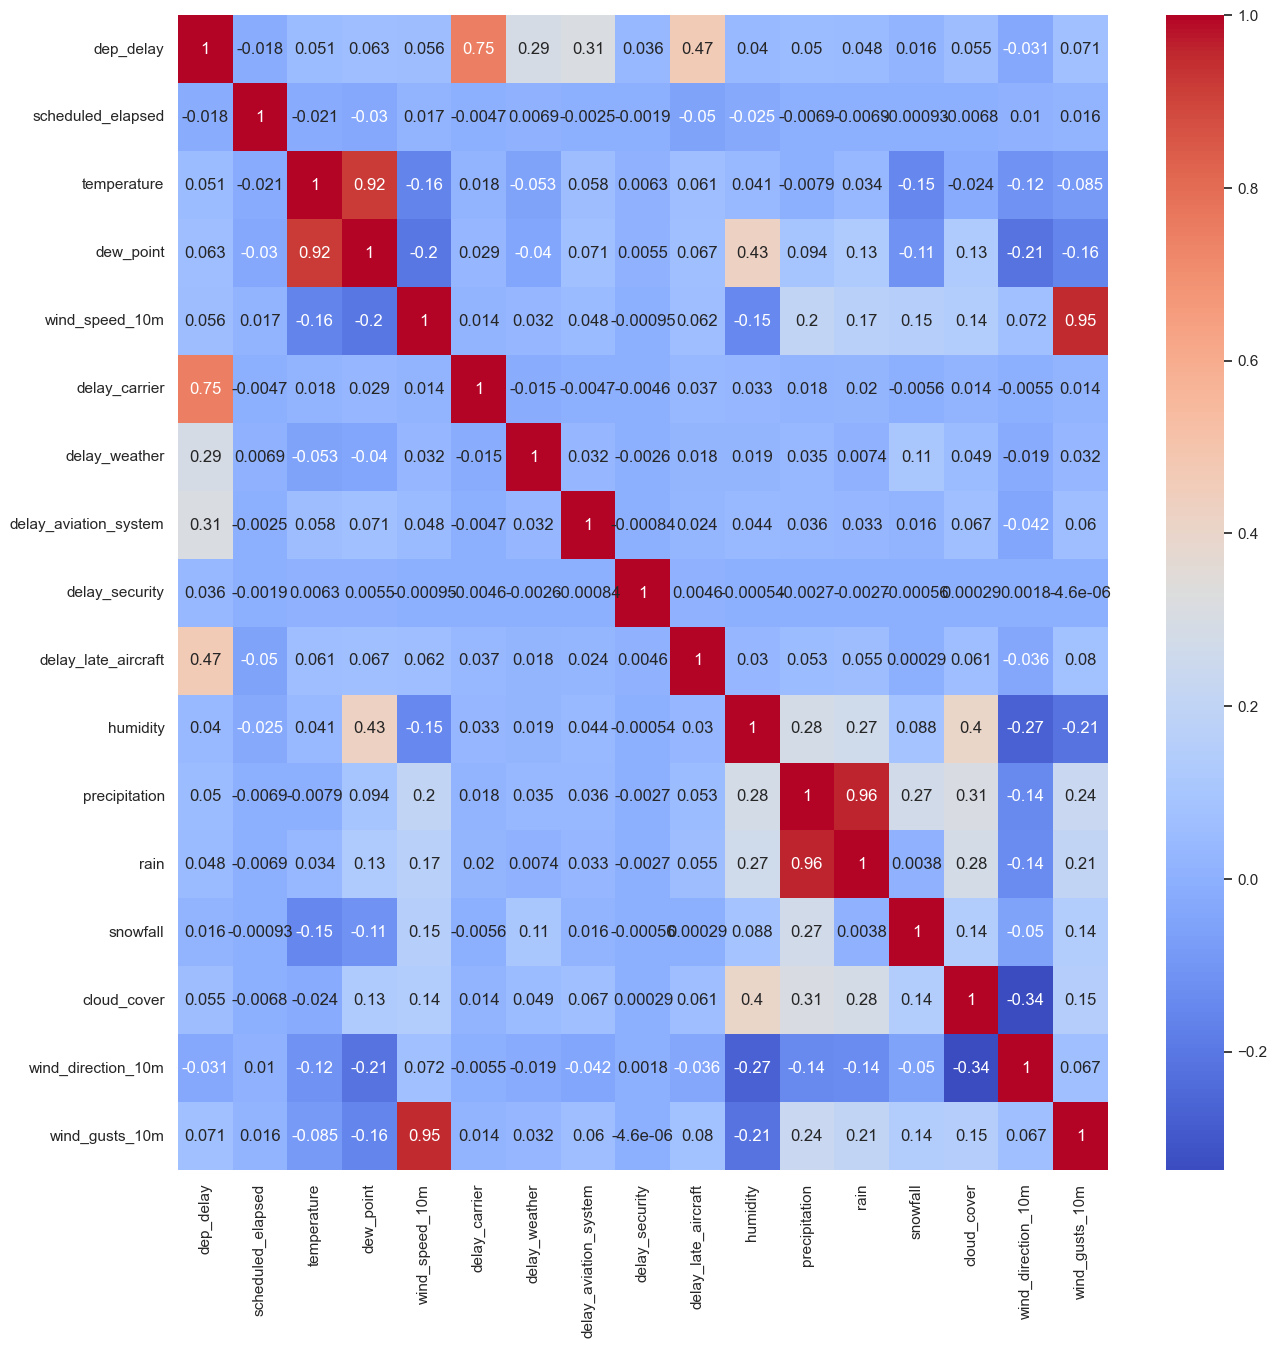

In [58]:
#Trying correlation based on data types
temp_df_1 = data[numerical_cols]

std_scaler = StandardScaler()
std_scaler.fit_transform(temp_df_1)

corr_matrix = temp_df_1.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.savefig('C:/Users/sonal/flight-delay-prediction/plots/correlation_numerical_columns.png') 
plt.show()

In [59]:
#Cramers test
#Checking the correlation between categorical variables using Cramer's test 
#categorial variables cannot be plotted using heatmap/correlation matrix
#Cramer's test show association between variables, 0 would mean no association and 1 would mean perfectly associated
#Calculated based on Chi-square contingency test and considers all the categories in each variable
def check_cat_cat_corr(data, cat_cols):
    #empty dataframes to store p values and cramers values
    p_values = pd.DataFrame(index=cat_cols, columns=cat_cols)
    cramers_v = pd.DataFrame(index=cat_cols, columns=cat_cols)

    for i in range(len(cat_cols)):
        for j in range(i+1, len(cat_cols)):
            contingency_table = pd.crosstab(data[cat_cols[i]], data[cat_cols[j]])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            p_values.loc[cat_cols[i], cat_cols[j]] = p
            p_values.loc[cat_cols[j], cat_cols[i]] = p
            n = contingency_table.values.sum()
            phi2 = chi2/n
            r, k = contingency_table.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            cramers_v.loc[cat_cols[i], cat_cols[j]] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
            cramers_v.loc[cat_cols[j], cat_cols[i]] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return cramers_v
    
cat_cat_corr = check_cat_cat_corr(data, categorical_cols)
cat_cat_corr

,flight_num,dest,weekend,month,year,delay_category,season,wind_alert,is_holiday,weather_code,carrier,day_of_week
flight_num,NaN,0.712502,0.076501,0.258023,0.580008,0.104233,0.344094,0.040172,0.09612,0.058761,0.910991,0.0
dest,0.712502,NaN,0.034017,0.042209,0.106705,0.051825,0.066307,0.020234,0.019051,0.017274,0.573885,0.022289
weekend,0.076501,0.034017,NaN,0.027269,0.030908,0.002124,0.014894,0.029868,0.032059,0.023522,0.009408,0.999985
month,0.258023,0.042209,0.027269,NaN,0.128473,0.041894,0.999977,0.073239,0.169222,0.094245,0.023309,0.021744
year,0.580008,0.106705,0.030908,0.128473,NaN,0.044119,0.134621,0.060475,0.023311,0.056585,0.133729,0.017488
delay_category,0.104233,0.051825,0.002124,0.041894,0.044119,NaN,0.041684,0.026664,0.008366,0.054995,0.019533,0.012442
season,0.344094,0.066307,0.014894,0.999977,0.134621,0.041684,NaN,0.058211,0.130934,0.143367,0.011646,0.019026
wind_alert,0.040172,0.020234,0.029868,0.073239,0.060475,0.026664,0.058211,NaN,0.0,0.230424,0.007841,0.042461
is_holiday,0.09612,0.019051,0.032059,0.169222,0.023311,0.008366,0.130934,0.0,NaN,0.025451,0.007506,0.041175
weather_code,0.058761,0.017274,0.023522,0.094245,0.056585,0.054995,0.143367,0.230424,0.025451,NaN,0.016057,0.039365


In [60]:
#Point Biserial correlation
#used this to see the correlation between categorical and numerical variables
#Label encoder would encode categorical variables into numerical values
def check_num_cat_corr(data, num_vars, cat_vars):
    le = LabelEncoder()
    corr_dict = {}
    #Looping through each combination of categorical and continuous variables
    for cat_var in cat_vars:
        corr_dict[cat_var] = {}
        for num_var in num_vars:
            data[num_var] = pd.to_numeric(data[num_var], errors='coerce')
            #Calculating the correlation and p-value using pointbiserialr
            correlation, p_value = pointbiserialr(data[num_var], le.fit_transform(data[cat_var]))
            corr_dict[cat_var][num_var] = correlation

    corr_df = pd.DataFrame(corr_dict)
    return corr_df
    
cat_num_corr = check_num_cat_corr(data, numerical_cols, categorical_cols)
cat_num_corr

,flight_num,dest,weekend,month,year,delay_category,season,wind_alert,is_holiday,weather_code,carrier,day_of_week
dep_delay,0.016294,-0.013015,0.004343,-0.010147,-0.001394,0.784791,0.005023,0.023092,-0.005516,0.078721,0.007988,-0.016814
scheduled_elapsed,-0.365693,0.499078,-0.015901,-0.010753,-0.003934,-0.029475,-0.028370,0.001704,0.003505,-0.005498,0.086416,0.008105
temperature,0.002890,-0.009919,-0.030143,0.321174,0.000027,0.062811,0.612946,-0.039504,-0.060815,-0.097058,0.007738,0.026156
dew_point,0.004950,-0.008467,-0.035046,0.324841,0.026018,0.068864,0.581059,-0.024289,-0.059110,0.058783,-0.000172,0.020723
wind_speed_10m,0.017104,-0.001176,-0.000007,-0.104613,0.039323,0.066212,-0.128109,0.274788,0.002499,0.204407,0.005200,-0.044878
delay_carrier,0.005064,-0.007511,0.012286,0.000258,0.025327,0.482250,0.004928,0.007194,0.003221,0.017204,0.010199,-0.009723
delay_weather,-0.001225,-0.000625,0.003669,-0.028613,-0.038824,0.200072,-0.045477,0.012378,-0.004238,0.116822,0.005917,-0.012500
delay_aviation_system,0.005997,0.009384,-0.009407,-0.002540,-0.020901,0.286182,0.013729,0.016703,-0.009062,0.079109,-0.006091,-0.006541
delay_security,-0.000064,0.001559,0.001643,0.001396,0.000913,0.050571,0.002555,0.001111,-0.000750,-0.000364,-0.006502,0.000148
delay_late_aircraft,0.023216,-0.026175,-0.009769,-0.010663,-0.010711,0.477935,0.009693,0.024911,-0.010614,0.072179,-0.039942,-0.010636


In [62]:
# Covariance Analysis
#Numerical columns for Time series analysis
num_columns_ts = data.select_dtypes(include=[np.number])

scaler = StandardScaler()
standardized_data = scaler.fit_transform(num_columns_ts)

standardized_df = pd.DataFrame(standardized_data, columns=num_columns_ts.columns)
covariance_matrix = standardized_df.cov()

#cov_with_target = covariance_matrix['dep_delay'].drop('dep_delay')
cov_with_target = covariance_matrix['delay_category'].drop('delay_category')
sorted_cov_with_target = cov_with_target.sort_values(ascending=False)

print("Covariance with Target Variable (flight_delay) - Sorted:")
print(sorted_cov_with_target)
#-1 indicates a perfect negative correlation, 
#1 indicates a perfect positive correlation, and 0 indicates no correlation.
#My understanding from this delay types increases delay time which is common sense but past that, 
#if wind gusts and wind speed etc have the next highest linear relationship
#Carrier related delay has the highest linearity

Covariance with Target Variable (flight_delay) - Sorted:
dep_delay                0.784796
delay_carrier            0.482253
delay_late_aircraft      0.477938
delay_aviation_system    0.286184
delay_weather            0.200073
taxi_out_time            0.148460
is_day                   0.104774
weather_code             0.091692
wind_gusts_10m           0.087061
cloud_cover              0.069457
dew_point                0.068865
wind_speed_10m           0.066212
temperature              0.062811
rain                     0.058781
precipitation            0.057499
delay_security           0.050572
wind_speed_100m          0.048373
humidity                 0.028954
actual_elapsed           0.027575
flight_num               0.017117
snowfall                 0.003734
weekend                  0.003412
day                     -0.011513
month                   -0.017271
week                    -0.018427
year                    -0.019165
scheduled_elapsed       -0.029476
wind_direction_100m     -

In [64]:
# Calculate Pearson's correlation coefficient with the target variable
correlation_with_target = {}
for column in standardized_df:
#    if column != 'dep_delay':  # Exclude the target variable
#        correlation, _ = pearsonr(standardized_df[column], standardized_df['dep_delay'])
    if column != 'delay_category':  # Exclude the target variable
        correlation, _ = pearsonr(standardized_df[column], standardized_df['delay_category'])
        correlation_with_target[column] = correlation

sorted_correlation_with_target = dict(sorted(correlation_with_target.items(), key=lambda item: abs(item[1]), reverse=True))

print("Pearson's Correlation with Target Variable (flight_delay) - Sorted:")
print(sorted_correlation_with_target)
#Results came out very similar to Covariance so not trying another one

Pearson's Correlation with Target Variable (flight_delay) - Sorted:
{'dep_delay': 0.784791093947073, 'delay_carrier': 0.4822499309542149, 'delay_late_aircraft': 0.4779349165118937, 'delay_aviation_system': 0.28618200669896937, 'delay_weather': 0.2000715095803713, 'taxi_out_time': 0.14845928054708313, 'is_day': 0.10477290638029794, 'weather_code': 0.09169120137827555, 'wind_gusts_10m': 0.08706007087103321, 'pressure': -0.06968000528799202, 'cloud_cover': 0.06945687243680086, 'surface_pressure': -0.06928449262251084, 'dew_point': 0.06886435816434952, 'wind_speed_10m': 0.06621194673571854, 'temperature': 0.06281071531266998, 'rain': 0.058781128294830995, 'precipitation': 0.057499095435636735, 'delay_security': 0.05057126913076189, 'wind_speed_100m': 0.04837316561907144, 'wind_direction_10m': -0.040675269026568234, 'wind_direction_100m': -0.04035864552482045, 'scheduled_elapsed': -0.029475338093264, 'humidity': 0.028954223548256296, 'actual_elapsed': 0.027574685539830515, 'year': -0.019165

# Feature Selection

In [74]:
features = data[numerical_cols + categorical_cols]
target = data['delay_category']

le = LabelEncoder()
for col in categorical_cols:
    features.loc[:, col] = le.fit_transform(features.loc[:, col])

# Apply SelectKBest with k=22
selector = SelectKBest(score_func=f_classif, k=22)

X_new = selector.fit_transform(features, target)

selected_indices = selector.get_support(indices=True)
selected_features = [features.columns[idx] for idx in selected_indices]

feature_scores = selector.scores_[selected_indices]
print("Selected features:", selected_features)

pd.DataFrame({'Feature': selected_features, 'Scores': feature_scores}).sort_values(by='Scores', ascending=False)

C:\Users\sonal\AppData\Local\Temp\ipykernel_27908\4109348521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, col] = le.fit_transform(features.loc[:, col])
C:\Users\sonal\AppData\Local\Temp\ipykernel_27908\4109348521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, col] = le.fit_transform(features.loc[:, col])
C:\Users\sonal\AppData\Local\Temp\ipykernel_27908\4109348521.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the valu

Selected features: ['dep_delay', 'scheduled_elapsed', 'temperature', 'dew_point', 'wind_speed_10m', 'delay_carrier', 'delay_weather', 'delay_aviation_system', 'delay_security', 'delay_late_aircraft', 'humidity', 'precipitation', 'rain', 'snowfall', 'cloud_cover', 'wind_direction_10m', 'wind_gusts_10m', 'year', 'delay_category', 'wind_alert', 'weather_code', 'carrier']


C:\Users\sonal\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


,Feature,Scores
18,delay_category,inf
0,dep_delay,1.537995e+05
5,delay_carrier,2.195940e+04
9,delay_late_aircraft,1.571984e+04
7,delay_aviation_system,4.781076e+03
6,delay_weather,3.000556e+03
20,weather_code,3.672662e+02
16,wind_gusts_10m,3.352434e+02
3,dew_point,2.113330e+02
14,cloud_cover,2.089814e+02


**Based on the SelectKBest method, delay_category and dep_delay have the top 2 highest scores, this is invalid as these 2 in a way represent the target variable directly. Besides these, delay carrier has the highest score which would indicate that the carrier related delays is highly significant in Flight departure delays. Other notable features include delay due to aviation system and weather.**

**This also indicates that weather related parameters like wind gusts, wind speed, cloud cover, humidity have high importance to the target feature whereas time related variables rank quite low in importance**

In [66]:
data.columns

Index(['carrier', 'flight_date', 'flight_num', 'dest', 'scheduled_dep',
       'actual_dep', 'scheduled_elapsed', 'actual_elapsed', 'dep_delay',
       'wheels_off_time', 'taxi_out_time', 'delay_carrier', 'delay_weather',
       'delay_aviation_system', 'delay_security', 'delay_late_aircraft',
       'combined_datetime', 'temperature', 'humidity', 'dew_point',
       'precipitation', 'rain', 'snowfall', 'weather_code', 'pressure',
       'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 'is_day',
       'delay_category', 'year', 'day', 'month', 'is_holiday', 'season',
       'day_of_week', 'weekend', 'wind_alert', 'week'],
      dtype='object')

In [67]:
#Saving engineered features to a file to use for modelling later
data.to_csv('C:/Users/sonal/flight-delay-prediction/dataset/flight_delay_engineered.csv',index=False)